In [19]:
import os,glob
import math
import re
import sys#sys.path.append('../../src')
import time
import subprocess

from pathlib import Path
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import pickle

from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from swc_handler import parse_swc, write_swc
from morph_topo.morphology import Morphology

# 42k reconstruction mapping

In [20]:
df_soma200k = pd.read_csv('../assets/soma200k_swc42k_xyz_region671.csv',index_col=0)
df_soma200k['brainid'] = df_soma200k['brainid'].apply(str)
df_soma200k['swc42k_raw_somaxyz_dist'] = df_soma200k['swc42k_raw_somaxyz_dist'].apply(float)
df_soma200k['regi_somaregion_n671_u32'] = df_soma200k['regi_somaregion_n671_u32'].apply(int)
df_soma200k['regi_somaregion'] = df_soma200k['regi_somaregion'].apply(str)
df_soma200k['regi_somaregion_n671_u32_check'] = df_soma200k['regi_somaregion_n671_u32_check'].apply(int)
df_soma200k['regi_somaregion_check'] = df_soma200k['regi_somaregion_check'].apply(str)
df_swc42k = df_soma200k[df_soma200k['swc42k_raw_somaxyz_dist']!=-1]
df_swc42k

,brainid,raw_somaxyz,swc42k_raw_somaxyz,swc42k_raw_somaxyz_dist,raw_somaregion,regi_somaxyz,swc42k_regi_somaxyz,regi_somaregion_n671_u32,regi_somaregion,regi_somaregion_n671_u32_check,regi_somaregion_check
3,15257,"[9707.336, 28942.707, 4827.952]","[9707.34, 28942.8, 4827.96]",0.093429,NaN,"[279.613, 180.116, 88.527]","[279.441, 180.216, 88.585]",672,CP,672,CP
4,15257,"[6884.128, 14090.333, 3235.582]","[6884.12, 14090.34, 3235.58]",0.010817,NaN,"[207.738, 254.492, 308.483]","[207.515, 254.637, 308.555]",342,SI,342,SI
5,15257,"[9347.471, 17057.223, 2969.26]","[9347.48, 17057.22, 2969.26]",0.009487,NaN,"[191.479, 214.211, 260.891]","[191.472, 214.272, 260.957]",351,BST,351,BST
6,15257,"[9445.759, 17075.385, 3105.61]","[9445.76, 17075.38, 3105.62]",0.011225,NaN,"[199.306, 209.825, 259.966]","[199.183, 209.941, 260.058]",900,aco,0,nan
7,15257,"[9514.604, 16966.244, 2999.682]","[9514.6, 16966.24, 2999.68]",0.006000,NaN,"[193.223, 210.47, 261.773]","[192.997, 210.62, 261.857]",900,aco,0,nan
...,...,...,...,...,...,...,...,...,...,...,...
227575,236174,"[17563.297, 28759.148, 6013.61]","[17563.3, 28759.2, 6013.6]",0.053038,NaN,"[300.504, 220.077, 401.126]","[300.345, 220.046, 401.054]",961,PIR,961,PIR
227576,236174,"[18176.244, 24154.77, 6192.542]","[18176.24, 24154.8, 6192.54]",0.030332,NaN,"[306.343, 239.819, 332.601]","[306.177, 239.769, 332.543]",780,PA,780,PA
227577,236174,"[18117.527, 24033.283, 6208.595]","[18117.52, 24033.2, 6208.6]",0.083445,NaN,"[306.815, 239.014, 330.559]","[306.649, 238.963, 330.499]",780,PA,780,PA
227579,236174,"[9570.51, 7845.859, 6146.163]","[9570.5, 7845.86, 6146.16]",0.010488,NaN,"[297.042, 126.665, 71.783]","[296.856, 126.607, 71.728]",156,AUDd6a,156,AUDd6a


In [22]:
df_swc42k['swc1891_swcfile_brain'] = ['']*len(df_swc42k)
df_swc42k['swc1891_swcfile'] = ['']*len(df_swc42k)
df_swc42k['swc1891_raw_somaxyz'] = ['[-1, -1, -1]']*len(df_swc42k)
df_swc42k['swc1891_raw_somaxyz_dist'] = [-1]*len(df_swc42k)
df_mapmarker = df_swc42k['raw_somaxyz'].apply(eval)
df_mapmarker

3          [9707.336, 28942.707, 4827.952]
4          [6884.128, 14090.333, 3235.582]
5           [9347.471, 17057.223, 2969.26]
6           [9445.759, 17075.385, 3105.61]
7          [9514.604, 16966.244, 2999.682]
                        ...               
227575     [17563.297, 28759.148, 6013.61]
227576     [18176.244, 24154.77, 6192.542]
227577    [18117.527, 24033.283, 6208.595]
227579       [9570.51, 7845.859, 6146.163]
227580        [9854.37, 7212.32, 6230.657]
Name: raw_somaxyz, Length: 42829, dtype: object

In [24]:
def get_firstsoma_xyz(tree,c,i,x,y,z):
    for leaf in tree:
        if leaf[c]==i:
            return [leaf[x],leaf[y],leaf[z]]

def get_dist(xyz):
    x,y,z = xyz
    return math.sqrt(x**2+y**2+z**2)

swcfilelist = []
brainlist = []
markerlist = []
dendriticsomalist = []
somashiftlist = []
raw_1891swc_dir = '/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_01_10/registration/S0_Unregistered/'
s = 0
for brain in os.listdir(raw_1891swc_dir):
    #df_brain = df_swc42k[df_swc42k['brainid']==brain]
    for swcname in os.listdir(raw_1891swc_dir+'/'+brain):
        s += 1
        swcfile = f'{raw_1891swc_dir}/{brain}/{swcname}'
        swcfilelist.append(swcfile)        
        brainlist.append(brain)
        swctree = parse_swc(swcfile)
        x,y,z = get_firstsoma_xyz(swctree,6,-1,2,3,4)
        soma = [x,y,z]
        dendriticsomalist.append(soma)
        if 'x' not in swcname: 
            marker = ''
            shift = -1
        else: 
            zz,xx,yy = swcname.split('.')[0].split('_')[1:]
            marker = [int(xx[1:]),int(yy[1:]),int(zz)]            
            shift = round(get_dist(abs(np.array(soma)-np.array(marker))),2)
        markerlist.append(marker)
        somashiftlist.append(shift)
        print(s,swcname,brain,marker,soma,shift)
df_1891swc = pd.DataFrame(np.array([brainlist,swcfilelist,markerlist,dendriticsomalist,somashiftlist]).T,
                          columns=['brain','swcfile','marker','soma','shift'])
df_1891swc

1 18470_3227_x19287_y16117.swc 18470 [19287, 16117, 3227] [19285.824, 16118.272, 3226.048] 1.98
2 18470_4630_x23468_y24795.swc 18470 [23468, 24795, 4630] [23461.889, 24791.424, 4625.376] 8.46
3 18470_3582_x22459_y29708.swc 18470 [22459, 29708, 3582] [22466.176, 29704.832, 3582.944] 7.9
4 18464_00010.swc 18464  [9476.224, 10896.32, 3775.024] -1
5 18464_00191.swc 18464  [8564.8, 10892.608, 7064.88] -1
6 18464_00042.swc 18464  [9221.44, 12594.432, 5652.0] -1
7 18464_00193.swc 18464  [9577.344, 9988.8, 6562.816] -1
8 18464_00127.swc 18464  [10596.928, 14245.824, 5483.952] -1
9 18464_00143.swc 18464  [23214.783, 13878.016, 5162.0] -1
10 18464_00031.swc 18464  [9608.896, 9686.592, 6231.76] -1
11 18464_00183.swc 18464  [24048.576, 13519.424, 5266.16] -1
12 18464_00052.swc 18464  [9066.112, 12369.728, 5930.208] -1
13 18464_00196.swc 18464  [21900.416, 10258.816, 5509.968] -1
14 18464_00197.swc 18464  [22289.6, 10401.216, 5442.96] -1
15 18464_00141.swc 18464  [25463.168, 14764.8, 3609.008] -1
1

130 18465_00309.swc 18465  [27246.912, 18833.279, 5191.184] -1
131 18465_00054.swc 18465  [12365.504, 7229.12, 5403.168] -1
132 18465_00229.swc 18465  [10553.792, 13300.48, 5699.744] -1
133 18465_00312.swc 18465  [26809.6, 11673.792, 6741.952] -1
134 18465_00001.swc 18465  [7656.0, 9722.496, 5019.344] -1
135 18465_00082.swc 18465  [10410.816, 12948.992, 5541.84] -1
136 18465_00209.swc 18465  [13884.8, 18216.129, 2675.984] -1
137 18465_00044.swc 18465  [9585.92, 11469.888, 4306.0] -1
138 18465_00303.swc 18465  [25046.977, 13987.2, 5815.984] -1
139 pre_18465_00373.swc 18465  [10297.1, 8120.18, 6465.29] -1
140 18465_00235.swc 18465  [10484.992, 14355.968, 5224.992] -1
141 18465_00246.swc 18465  [9742.976, 18177.023, 5235.008] -1
142 18465_00030.swc 18465  [9022.272, 9409.024, 4251.104] -1
143 18465_00109.swc 18465  [26058.176, 10885.184, 5434.496] -1
144 18465_00056.swc 18465  [10822.784, 10776.0, 5380.016] -1
145 18465_00238.swc 18465  [10557.12, 14070.272, 5707.856] -1
146 18465_00035.s

263 18465_00305.swc 18465  [24999.424, 15244.096, 5250.304] -1
264 18465_00264.swc 18465  [26510.721, 15401.984, 3753.184] -1
265 18465_00285.swc 18465  [27654.016, 18623.488, 5118.016] -1
266 18465_00286.swc 18465  [24678.977, 13172.928, 5234.832] -1
267 18465_00141.swc 18465  [26635.713, 12045.504, 5826.256] -1
268 18465_00111.swc 18465  [26054.527, 10597.888, 5478.512] -1
269 pre_18465_00370.swc 18465  [10004.095, 8867.295, 6394.798] -1
270 18465_00007.swc 18465  [8699.136, 9995.712, 4822.368] -1
271 18465_00155.swc 18465  [6422.272, 14561.6, 4759.056] -1
272 18465_00045.swc 18465  [9008.448, 11427.776, 4818.976] -1
273 191812_3163_x6264_y21524.swc 191812 [6264, 21524, 3163] [6255.808, 21516.031, 3158.528] 12.27
274 191812_5221_x9028_y25900.swc 191812 [9028, 25900, 5221] [9010.496, 25892.992, 5219.248] 18.94
275 191812_2978_x7903_y22705.swc 191812 [7903, 22705, 2978] [7893.312, 22704.129, 2972.96] 10.96
276 191812_5586_x4875_y23378.swc 191812 [4875, 23378, 5586] [4870.72, 23374.271,

353 18867_7583_x22567_y18119.swc 18867 [22567, 18119, 7583] [22567.104, 18118.783, 7583.424] 0.49
354 18867_4677_x24410_y14710.swc 18867 [24410, 14710, 4677] [24403.969, 14700.8, 4675.248] 11.14
355 18867_4724_x12558_y16835.swc 18867 [12558, 16835, 4724] [12558.272, 16835.52, 4724.224] 0.63
356 18867_6003_x18592_y6204.swc 18867 [18592, 6204, 6003] [18551.871, 6193.344, 5991.936] 42.97
357 18867_4689_x11723_y7039.swc 18867 [11723, 7039, 4689] [11702.592, 7006.464, 4675.008] 40.88
358 18867_4801_x7068_y12938.swc 18867 [7068, 12938, 4801] [7049.024, 12932.992, 4800.992] 19.63
359 18867_6986_x31479_y5932.swc 18867 [31479, 5932, 6986] [31479.871, 5932.16, 6986.8] 1.19
360 18867_5640_x21236_y5683.swc 18867 [21236, 5683, 5640] [21236.287, 5683.776, 5640.256] 0.87
361 18867_4605_x30309_y8068.swc 18867 [30309, 8068, 4605] [30299.52, 8068.288, 4595.616] 13.34
362 18867_5203_x10027_y7237.swc 18867 [10027, 7237, 5203] [10034.496, 7235.776, 5200.144] 8.11
363 18867_4421_x31775_y9812.swc 18867 [3177

466 18458_00101.swc 18458  [12341.568, 11183.808, 6308.496] -1
467 18458_00424.swc 18458  [13473.984, 12787.2, 5516.752] -1
468 18458_00056.swc 18458  [12493.312, 10088.32, 6089.088] -1
469 18458_00612.swc 18458  [14635.2, 9640.32, 6248.0] -1
470 18458_00376.swc 18458  [19319.104, 15082.304, 4979.136] -1
471 pre_18458_00351.swc 18458  [25833.0, 7583.0, 5593.0] -1
472 18458_00580.swc 18458  [26806.977, 15139.008, 5368.992] -1
473 18458_00102.swc 18458  [12268.288, 11128.128, 6396.608] -1
474 18458_00086.swc 18458  [13816.896, 10405.184, 6123.056] -1
475 18458_00351.swc 18458  [10646.016, 14110.016, 4242.0] -1
476 18458_00122.swc 18458  [13954.304, 12053.568, 5674.048] -1
477 18458_00561.swc 18458  [28545.408, 13321.6, 5795.824] -1
478 18458_00048.swc 18458  [14370.0, 9252.0, 5618.0] -1
479 pre_18458_00348.swc 18458  [25668.998, 7747.0, 5450.981] -1
480 18458_00250.swc 18458  [29374.207, 10288.512, 6172.16] -1
481 18458_00277.swc 18458  [28132.992, 12294.016, 5655.12] -1
482 18458_00460.

592 17302_00065.swc 17302  [21126.527, 20896.703, 4878.976] -1
593 17302_00076.swc 17302  [15831.616, 38808.0, 5219.744] -1
594 17302_00049.swc 17302  [20503.424, 20346.496, 5222.016] -1
595 17302_00108.swc 17302  [17832.0, 40337.984, 2262.0] -1
596 17302_00114.swc 17302  [16635.008, 39155.008, 4388.0] -1
597 17302_00124.swc 17302  [19112.0, 41280.0, 2798.0] -1
598 17302_00007.swc 17302  [16998.912, 15661.12, 3203.008] -1
599 18864_2086_x2903_y21496.swc 18864 [2903, 21496, 2086] [2909.888, 21493.119, 2084.784] 7.56
600 18864_00021.swc 18864  [4095.872, 7977.92, 4307.008] -1
601 18864_00023.swc 18864  [4115.008, 6961.024, 4864.0] -1
602 18864_5099_x6368_y29941.swc 18864 [6368, 29941, 5099] [6411.008, 29958.016, 5120.0] 50.8
603 pre_18864_00059.swc 18864  [3804.026, 11109.239, 3833.988] -1
604 18864_6956_x8154_y30811.swc 18864 [8154, 30811, 6956] [8153.984, 30811.393, 6956.304] 0.5
605 18864_2520_x2913_y22642.swc 18864 [2913, 22642, 2520] [2915.072, 22636.225, 2509.792] 11.91
606 18864_4

704 pre_18864_00427.swc 18864  [2819.584, 18105.6, 3245.843] -1
705 pre_18864_00051.swc 18864  [3629.317, 24690.734, 4142.004] -1
706 18864_4429_x7945_y3080.swc 18864 [7945, 3080, 4429] [7947.328, 3081.152, 4419.536] 9.81
707 18864_00043.swc 18864  [8977.024, 4713.024, 3238.0] -1
708 18864_4693_x10912_y2095.swc 18864 [10912, 2095, 4693] [10906.688, 2101.056, 4691.216] 8.25
709 pre_18864_00044.swc 18864  [3595.103, 25897.553, 3679.098] -1
710 pre_18864_00088.swc 18864  [4315.0, 24999.0, 6571.0] -1
711 18864_00057.swc 18864  [6381.556, 16443.334, 1973.0] -1
712 pre_18864_00413.swc 18864  [2343.0, 19900.0, 2526.0] -1
713 18864_6821_x5144_y6844.swc 18864 [5144, 6844, 6821] [5144.896, 6844.224, 6821.168] 0.94
714 18455_00041.swc 18455  [31545.984, 10774.016, 5058.0] -1
715 18455_00045.swc 18455  [28318.016, 9910.016, 6218.0] -1
716 18455_00123.swc 18455  [14488.0, 12048.0, 5366.0] -1
717 18455_00220.swc 18455  [29693.695, 15922.176, 4400.112] -1
718 18455_00143.swc 18455  [13129.984, 11870.

829 18455_00257.swc 18455  [26660.416, 12273.088, 6138.784] -1
830 18455_00136.swc 18455  [12433.92, 11872.128, 5744.288] -1
831 18455_00007.swc 18455  [12159.104, 10717.12, 3579.104] -1
832 18868_2621_x11765_y8944.swc 18868 [11765, 8944, 2621] [11747.008, 8933.184, 2614.896] 21.86
833 18868_3931_x26823_y7496.swc 18868 [26823, 7496, 3931] [26815.488, 7488.128, 3924.144] 12.86
834 18868_2584_x14386_y13639.swc 18868 [14386, 13639, 2584] [14385.472, 13639.424, 2584.352] 0.76
835 18868_5686_x9887_y5415.swc 18868 [9887, 5415, 5686] [9876.864, 5402.944, 5683.744] 15.91
836 18868_5723_x7031_y7203.swc 18868 [7031, 7203, 5723] [7018.688, 7189.76, 5721.248] 18.16
837 18868_3853_x29683_y10294.swc 18868 [29683, 10294, 3853] [29664.896, 10271.296, 3849.968] 29.2
838 18868_4132_x11881_y6094.swc 18868 [11881, 6094, 4132] [11869.312, 6686.912, 4123.728] 593.08
839 18868_3009_x28076_y11485.swc 18868 [28076, 11485, 3009] [28055.297, 11484.288, 3000.176] 22.52
840 18868_3453_x28753_y10380.swc 18868 [2875

917 18047_3132_x24052_y12385.swc 18047 [24052, 12385, 3132] [24066.881, 12380.032, 3131.792] 15.69
918 18047_4141_x14168_y9063.swc 18047 [14168, 9063, 4141] [14164.224, 9066.624, 4134.688] 8.2
919 pre_18047_00009.swc 18047  [10052.0, 12665.0, 3177.0] -1
920 18047_5719_x25513_y7957.swc 18047 [25513, 7957, 5719] [25513.023, 7953.344, 5712.816] 7.18
921 18047_00047.swc 18047  [16062.08, 14806.976, 2443.056] -1
922 18047_2622_x11862_y12983.swc 18047 [11862, 12983, 2622] [11856.192, 12989.888, 2619.776] 9.28
923 18452_4126_x15225_y20986.swc 18452 [15225, 20986, 4126] [15214.016, 21003.713, 4130.32] 21.29
924 18452_4536_x11274_y21067.swc 18452 [11274, 21067, 4536] [11283.712, 21074.176, 4541.6] 13.31
925 18452_4002_x10332_y17479.swc 18452 [10332, 17479, 4002] [10319.104, 17464.512, 4003.52] 19.46
926 18452_4272_x26686_y20064.swc 18452 [26686, 20064, 4272] [26679.615, 20080.512, 4273.936] 17.81
927 18452_7249_x11408_y2071.swc 18452 [11408, 2071, 7249] [11413.716, 2079.354, 7246.018] 10.55
928

1007 18869_5754_x7159_y3959.swc 18869 [7159, 3959, 5754] [7166.912, 3955.264, 5753.616] 8.76
1008 18869_4997_x13063_y4444.swc 18869 [13063, 4444, 4997] [13049.792, 4429.504, 4997.504] 19.62
1009 18869_3506_x6250_y6810.swc 18869 [6250, 6810, 3506] [6244.416, 6809.536, 3505.632] 5.62
1010 18869_5571_x8792_y4549.swc 18869 [8792, 4549, 5571] [8792.96, 4549.632, 5572.0] 1.52
1011 18869_5317_x6063_y4638.swc 18869 [6063, 4638, 5317] [6053.184, 4632.512, 5308.864] 13.88
1012 18869_5343_x5414_y5337.swc 18869 [5414, 5337, 5343] [5413.888, 5329.6, 5337.376] 9.3
1013 18869_5980_x7654_y3517.swc 18869 [7654, 3517, 5980] [7658.496, 3515.2, 5977.392] 5.5
1014 18869_3064_x20999_y7621.swc 18869 [20999, 7621, 3064] [20998.271, 7613.44, 3053.392] 13.05
1015 18869_5123_x17555_y3609.swc 18869 [17555, 3609, 5123] [17554.432, 3604.48, 5122.992] 4.56
1016 18869_3857_x22137_y7268.swc 18869 [22137, 7268, 3857] [22131.904, 7259.648, 3856.08] 9.83
1017 18869_6291_x15236_y3478.swc 18869 [15236, 3478, 6291] [15244.9

1095 18453_1924_x22284_y8069.swc 18453 [22284, 8069, 1924] [22281.217, 8061.44, 1918.944] 9.51
1096 18453_3704_x10450_y7387.swc 18453 [10450, 7387, 3704] [10434.688, 7376.704, 3692.144] 21.93
1097 18453_5228_x9833_y5221.swc 18453 [9833, 5221, 5228] [9833.856, 5221.888, 5228.48] 1.32
1098 18453_7007_x11486_y3611.swc 18453 [11486, 3611, 7007] [11476.48, 3608.512, 7003.504] 10.44
1099 18453_3147_x16721_y20510.swc 18453 [16721, 20510, 3147] [16720.896, 20509.568, 3146.512] 0.66
1100 18453_3767_x22604_y5643.swc 18453 [22604, 5643, 3767] [22598.721, 5646.4, 3763.456] 7.21
1101 18453_2645_x28684_y11703.swc 18453 [28684, 11703, 2645] [28683.008, 11693.888, 2643.104] 9.36
1102 18453_4497_x29287_y7176.swc 18453 [29287, 7176, 4497] [29273.984, 7161.664, 4478.016] 27.12
1103 18453_3766_x16118_y20931.swc 18453 [16118, 20931, 3766] [16118.272, 20931.713, 3766.544] 0.94
1104 18453_7132_x11495_y3152.swc 18453 [11495, 3152, 7132] [11486.592, 3139.136, 7128.256] 15.82
1105 18453_3218_x16785_y20581.swc 1

1194 17545_00040.swc 17545  [18316.801, 16064.384, 3152.816] -1
1195 17545_00068.swc 17545  [25819.393, 20115.969, 3384.544] -1
1196 17545_00050.swc 17545  [21348.416, 15148.032, 3565.36] -1
1197 17545_00129.swc 17545  [20745.408, 38576.32, 3738.528] -1
1198 17545_00053.swc 17545  [21894.08, 19320.512, 3134.032] -1
1199 17545_00075.swc 17545  [21272.832, 16130.176, 5515.92] -1
1200 17545_00130.swc 17545  [21856.0, 38004.609, 3596.304] -1
1201 17545_00073.swc 17545  [19511.168, 10228.224, 5494.48] -1
1202 17545_00144.swc 17545  [22782.016, 36590.785, 3382.896] -1
1203 17545_00154.swc 17545  [23056.129, 34636.031, 5325.776] -1
1204 17545_00095.swc 17545  [23705.984, 17292.992, 5931.008] -1
1205 17545_00029.swc 17545  [20603.328, 13002.88, 4073.328] -1
1206 17545_00138.swc 17545  [21681.217, 39019.07, 3664.848] -1
1207 17545_00063.swc 17545  [25899.072, 16375.808, 3984.992] -1
1208 17545_00065.swc 17545  [24075.775, 18663.871, 3430.288] -1
1209 17545_00030.swc 17545  [22518.207, 13446.4, 

1305 182724_2670_x5615_y13225.swc 182724 [5615, 13225, 2670] [5611.776, 13224.576, 2666.88] 4.51
1306 182724_2526_x7529_y21792.swc 182724 [7529, 21792, 2526] [7535.04, 21792.576, 2529.328] 6.92
1307 182724_5651_x9832_y25682.swc 182724 [9832, 25682, 5651] [9833.984, 25683.52, 5652.848] 3.11
1308 182724_2383_x9300_y17890.swc 182724 [9300, 17890, 2383] [9300.16, 17890.816, 2383.952] 1.26
1309 182724_5937_x3804_y11955.swc 182724 [3804, 11955, 5937] [3792.704, 11934.912, 5928.688] 24.5
1310 182724_4472_x5247_y12162.swc 182724 [5247, 12162, 4472] [5250.496, 12165.504, 4470.256] 5.25
1311 182724_2494_x6419_y20983.swc 182724 [6419, 20983, 2494] [6419.776, 20983.68, 2494.912] 1.38
1312 182724_4580_x5627_y9427.swc 182724 [5627, 9427, 4580] [5627.136, 9412.864, 4582.752] 14.4
1313 182724_5793_x8695_y5510.swc 182724 [8695, 5510, 5793] [8674.112, 5521.984, 5783.888] 25.75
1314 182724_5410_x4393_y11075.swc 182724 [4393, 11075, 5410] [4398.016, 11065.024, 5416.0] 12.68
1315 182724_2926_x5279_y13761.s

1398 18457_00111.swc 18457  [14705.984, 14370.816, 4897.2] -1
1399 18457_00146.swc 18457  [26385.793, 12448.384, 5320.016] -1
1400 18457_00007.swc 18457  [14011.008, 10702.208, 3541.984] -1
1401 18457_00170.swc 18457  [22718.592, 15409.408, 3118.656] -1
1402 18457_00090.swc 18457  [12954.688, 12813.824, 5408.864] -1
1403 18457_00023.swc 18457  [11579.008, 11688.0, 5760.0] -1
1404 18457_00088.swc 18457  [12740.608, 12200.896, 5339.76] -1
1405 18457_00049.swc 18457  [25634.176, 11174.976, 5612.992] -1
1406 18457_00120.swc 18457  [10685.376, 12745.472, 5487.936] -1
1407 18457_00114.swc 18457  [9814.528, 15451.392, 4572.8] -1
1408 18457_00062.swc 18457  [27016.703, 11155.776, 5901.392] -1
1409 18457_00015.swc 18457  [14931.968, 11625.024, 3199.008] -1
1410 18457_00112.swc 18457  [15894.976, 14450.112, 5350.064] -1
1411 18457_00043.swc 18457  [26376.0, 9756.224, 4330.144] -1
1412 18457_00018.swc 18457  [11545.216, 11129.088, 5657.088] -1
1413 18457_00188.swc 18457  [22844.031, 14481.024, 57

1529 18463_00001.swc 18463  [22006.783, 8278.208, 6282.224] -1
1530 18463_00020.swc 18463  [10040.0, 9340.032, 3956.0] -1
1531 18463_00055.swc 18463  [20585.217, 9083.904, 5707.952] -1
1532 18463_00004.swc 18463  [11624.0, 6518.016, 4656.0] -1
1533 18463_00068.swc 18463  [20195.775, 10354.432, 5874.096] -1
1534 18463_00038.swc 18463  [12326.4, 9645.568, 5709.872] -1
1535 18463_00040.swc 18463  [12485.888, 9938.688, 5784.416] -1
1536 18463_00071.swc 18463  [21552.385, 10488.512, 5793.248] -1
1537 18463_00021.swc 18463  [9793.984, 9638.016, 3748.0] -1
1538 18463_00061.swc 18463  [21339.008, 9241.856, 6308.016] -1
1539 18463_00007.swc 18463  [11683.776, 7276.352, 4335.088] -1
1540 18463_00066.swc 18463  [20943.615, 9860.096, 5604.016] -1
1541 18463_00057.swc 18463  [22029.312, 8987.2, 6044.272] -1
1542 18463_00028.swc 18463  [11428.992, 9197.12, 5962.224] -1
1543 18463_00027.swc 18463  [11521.984, 9030.016, 5757.424] -1
1544 18463_00075.swc 18463  [24958.016, 11129.984, 5546.0] -1
1545 18

1661 18454_00071.swc 18454  [12561.984, 12220.032, 5606.0] -1
1662 pre_18454_00450.swc 18454  [24872.0, 7503.0, 3844.0] -1
1663 18454_00066.swc 18454  [12092.032, 11505.984, 5622.0] -1
1664 18454_01093.swc 18454  [24656.0, 9628.992, 6351.008] -1
1665 18454_00002.swc 18454  [8062.272, 9099.904, 5056.752] -1
1666 18454_01079.swc 18454  [23830.0, 9498.0, 5908.0] -1
1667 18454_01049.swc 18454  [10592.128, 11454.08, 6011.968] -1
1668 18454_01096.swc 18454  [24051.969, 10232.0, 6082.0] -1
1669 18454_00111.swc 18454  [27337.023, 9552.0, 4018.0] -1
1670 18454_01110.swc 18454  [25468.031, 10272.0, 5842.0] -1
1671 18454_01027.swc 18454  [10425.984, 10337.984, 6106.0] -1
1672 18454_00021.swc 18454  [11092.928, 8839.36, 3992.0] -1
1673 18454_01004.swc 18454  [11294.016, 10905.984, 5358.0] -1
1674 18454_01125.swc 18454  [24675.969, 9987.968, 6280.0] -1
1675 18454_00070.swc 18454  [12017.984, 12065.984, 5916.0] -1
1676 18454_00152.swc 18454  [24689.279, 10898.176, 6739.168] -1
1677 18454_01041.swc 1

1795 18454_00048.swc 18454  [12894.4, 11840.128, 5473.856] -1
1796 18454_01009.swc 18454  [11113.984, 11678.016, 5494.0] -1
1797 18454_01005.swc 18454  [11097.984, 11094.016, 5472.0] -1
1798 pre_18454_00376.swc 18454  [24184.898, 7660.689, 3802.17] -1
1799 18454_00127.swc 18454  [23656.512, 9317.504, 5895.872] -1
1800 18454_01061.swc 18454  [11287.808, 11814.4, 5800.24] -1
1801 18454_01010.swc 18454  [11385.984, 11515.008, 5495.008] -1
1802 18454_01001.swc 18454  [10897.216, 11384.0, 5511.328] -1
1803 236174_3729_x15151_y26698.swc 236174 [15151, 26698, 3729] [15156.288, 26697.92, 3782.4] 53.66
1804 236174_5738_x11712_y6818.swc 236174 [11712, 6818, 5738] [11712.704, 6820.608, 5734.864] 4.14
1805 236174_2669_x10674_y13239.swc 236174 [10674, 13239, 2669] [10683.072, 13250.624, 2648.096] 25.58
1806 236174_7077_x14579_y30892.swc 236174 [14579, 30892, 7077] [14578.88, 30905.92, 7055.68] 25.46
1807 236174_3729_x13645_y9551.swc 236174 [13645, 9551, 3729] [13649.984, 9554.816, 3751.488] 23.35
1

1882 18461_5025_x23630_y4542.swc 18461 [23630, 4542, 5025] [23630.271, 4542.848, 5025.904] 1.27
1883 18461_4388_x5599_y5781.swc 18461 [5599, 5781, 4388] [5599.488, 5781.696, 4388.016] 0.85
1884 18461_3871_x7813_y3857.swc 18461 [7813, 3857, 3871] [7813.44, 3853.76, 3871.328] 3.29
1885 18461_4178_x16825_y2713.swc 18461 [16825, 2713, 4178] [16825.729, 2713.792, 4178.464] 1.17
1886 18461_4233_x19011_y2874.swc 18461 [19011, 2874, 4233] [19011.393, 2874.24, 4233.312] 0.56
1887 18461_4862_x17603_y2198.swc 18461 [17603, 2198, 4862] [17603.199, 2198.208, 4862.608] 0.67
1888 17786_00024.swc 17786  [21508.912, 31449.195, 1867.87] -1
1889 17786_00001.swc 17786  [20659.361, 20368.0, 1720.905] -1
1890 17786_00017.swc 17786  [20216.729, 20652.176, 1706.997] -1
1891 17786_00022.swc 17786  [21449.555, 31439.334, 1688.0] -1


<ipython-input-24-94f7291bbde1>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_1891swc = pd.DataFrame(np.array([brainlist,swcfilelist,markerlist,dendriticsomalist,somashiftlist]).T,


,brain,swcfile,marker,soma,shift
0,18470,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,"[19287, 16117, 3227]","[19285.824, 16118.272, 3226.048]",1.98
1,18470,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,"[23468, 24795, 4630]","[23461.889, 24791.424, 4625.376]",8.46
2,18470,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,"[22459, 29708, 3582]","[22466.176, 29704.832, 3582.944]",7.9
3,18464,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,,"[9476.224, 10896.32, 3775.024]",-1
4,18464,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,,"[8564.8, 10892.608, 7064.88]",-1
...,...,...,...,...,...
1886,18461,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,"[17603, 2198, 4862]","[17603.199, 2198.208, 4862.608]",0.67
1887,17786,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,,"[21508.912, 31449.195, 1867.87]",-1
1888,17786,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,,"[20659.361, 20368.0, 1720.905]",-1
1889,17786,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,,"[20216.729, 20652.176, 1706.997]",-1


In [26]:
dis_mat = distance_matrix(np.array(df_mapmarker.values.tolist()),np.array(dendriticsomalist))
distto42k = np.min(dis_mat,axis=0)
brainlist = np.array(brainlist)[distto42k<=20]
swcfilelist = np.array(swcfilelist)[distto42k<=20]
markerlist = np.array(markerlist)[distto42k<=20] 
dendriticsomalist = np.array(dendriticsomalist)[distto42k<=20]
somashiftlist = np.array(somashiftlist)[distto42k<=20]

dis_mat = distance_matrix(np.array(df_mapmarker.values.tolist()),dendriticsomalist)
distto42k = np.min(dis_mat,axis=0)
mapindexto42k = np.argmin(dis_mat,axis=0)
mapmarkerto42k = df_mapmarker.iloc[mapindexto42k]
mapiindexon42k = mapmarkerto42k.index

markerlist = [str(i) for i in markerlist]
dendriticsomalist = [str(i) for i in dendriticsomalist]

<ipython-input-26-755dc7d1f768>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  markerlist = np.array(markerlist)[distto42k<=20]


In [27]:
df_swc42k['swc1891_swcfile_brain'][mapiindexon42k] = brainlist
df_swc42k['swc1891_swcfile'][mapiindexon42k] = swcfilelist
df_swc42k['swc1891_raw_somaxyz'][mapiindexon42k] = dendriticsomalist
df_swc42k['swc1891_raw_somaxyz_dist'][mapiindexon42k] = distto42k
df_swc42k

<ipython-input-27-1224bed1c916>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_swc42k['swc1891_swcfile_brain'][mapiindexon42k] = brainlist
/home/lyf/anaconda3/envs/pytorch1.8/lib/python3.8/site-packages/pandas/core/series.py:1135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(indexer, value)
<ipython-input-27-1224bed1c916>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_swc42k['swc1891_swcfile'][mapiindexon42k

,brainid,raw_somaxyz,swc42k_raw_somaxyz,swc42k_raw_somaxyz_dist,raw_somaregion,regi_somaxyz,swc42k_regi_somaxyz,regi_somaregion_n671_u32,regi_somaregion,regi_somaregion_n671_u32_check,regi_somaregion_check,swc1891_swcfile_brain,swc1891_swcfile,swc1891_raw_somaxyz,swc1891_raw_somaxyz_dist
3,15257,"[9707.336, 28942.707, 4827.952]","[9707.34, 28942.8, 4827.96]",0.093429,NaN,"[279.613, 180.116, 88.527]","[279.441, 180.216, 88.585]",672,CP,672,CP,,,"[-1, -1, -1]",-1.0
4,15257,"[6884.128, 14090.333, 3235.582]","[6884.12, 14090.34, 3235.58]",0.010817,NaN,"[207.738, 254.492, 308.483]","[207.515, 254.637, 308.555]",342,SI,342,SI,,,"[-1, -1, -1]",-1.0
5,15257,"[9347.471, 17057.223, 2969.26]","[9347.48, 17057.22, 2969.26]",0.009487,NaN,"[191.479, 214.211, 260.891]","[191.472, 214.272, 260.957]",351,BST,351,BST,,,"[-1, -1, -1]",-1.0
6,15257,"[9445.759, 17075.385, 3105.61]","[9445.76, 17075.38, 3105.62]",0.011225,NaN,"[199.306, 209.825, 259.966]","[199.183, 209.941, 260.058]",900,aco,0,nan,,,"[-1, -1, -1]",-1.0
7,15257,"[9514.604, 16966.244, 2999.682]","[9514.6, 16966.24, 2999.68]",0.006000,NaN,"[193.223, 210.47, 261.773]","[192.997, 210.62, 261.857]",900,aco,0,nan,,,"[-1, -1, -1]",-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227575,236174,"[17563.297, 28759.148, 6013.61]","[17563.3, 28759.2, 6013.6]",0.053038,NaN,"[300.504, 220.077, 401.126]","[300.345, 220.046, 401.054]",961,PIR,961,PIR,,,"[-1, -1, -1]",-1.0
227576,236174,"[18176.244, 24154.77, 6192.542]","[18176.24, 24154.8, 6192.54]",0.030332,NaN,"[306.343, 239.819, 332.601]","[306.177, 239.769, 332.543]",780,PA,780,PA,,,"[-1, -1, -1]",-1.0
227577,236174,"[18117.527, 24033.283, 6208.595]","[18117.52, 24033.2, 6208.6]",0.083445,NaN,"[306.815, 239.014, 330.559]","[306.649, 238.963, 330.499]",780,PA,780,PA,,,"[-1, -1, -1]",-1.0
227579,236174,"[9570.51, 7845.859, 6146.163]","[9570.5, 7845.86, 6146.16]",0.010488,NaN,"[297.042, 126.665, 71.783]","[296.856, 126.607, 71.728]",156,AUDd6a,156,AUDd6a,,,"[-1, -1, -1]",-1.0


In [31]:
rank = df_swc42k.columns
new_rank = [0,1,2,3,12,13,14,4,5,6,7,8,9,10]
new_rank = rank[new_rank]
df_1891 = df_swc42k[new_rank]
df_1891.to_csv('../assets/swc42k_gs1891_xyz_region671.csv')
df_1891

,brainid,raw_somaxyz,swc42k_raw_somaxyz,swc42k_raw_somaxyz_dist,swc1891_swcfile,swc1891_raw_somaxyz,swc1891_raw_somaxyz_dist,raw_somaregion,regi_somaxyz,swc42k_regi_somaxyz,regi_somaregion_n671_u32,regi_somaregion,regi_somaregion_n671_u32_check,regi_somaregion_check
3,15257,"[9707.336, 28942.707, 4827.952]","[9707.34, 28942.8, 4827.96]",0.093429,,"[-1, -1, -1]",-1.0,NaN,"[279.613, 180.116, 88.527]","[279.441, 180.216, 88.585]",672,CP,672,CP
4,15257,"[6884.128, 14090.333, 3235.582]","[6884.12, 14090.34, 3235.58]",0.010817,,"[-1, -1, -1]",-1.0,NaN,"[207.738, 254.492, 308.483]","[207.515, 254.637, 308.555]",342,SI,342,SI
5,15257,"[9347.471, 17057.223, 2969.26]","[9347.48, 17057.22, 2969.26]",0.009487,,"[-1, -1, -1]",-1.0,NaN,"[191.479, 214.211, 260.891]","[191.472, 214.272, 260.957]",351,BST,351,BST
6,15257,"[9445.759, 17075.385, 3105.61]","[9445.76, 17075.38, 3105.62]",0.011225,,"[-1, -1, -1]",-1.0,NaN,"[199.306, 209.825, 259.966]","[199.183, 209.941, 260.058]",900,aco,0,nan
7,15257,"[9514.604, 16966.244, 2999.682]","[9514.6, 16966.24, 2999.68]",0.006000,,"[-1, -1, -1]",-1.0,NaN,"[193.223, 210.47, 261.773]","[192.997, 210.62, 261.857]",900,aco,0,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227575,236174,"[17563.297, 28759.148, 6013.61]","[17563.3, 28759.2, 6013.6]",0.053038,,"[-1, -1, -1]",-1.0,NaN,"[300.504, 220.077, 401.126]","[300.345, 220.046, 401.054]",961,PIR,961,PIR
227576,236174,"[18176.244, 24154.77, 6192.542]","[18176.24, 24154.8, 6192.54]",0.030332,,"[-1, -1, -1]",-1.0,NaN,"[306.343, 239.819, 332.601]","[306.177, 239.769, 332.543]",780,PA,780,PA
227577,236174,"[18117.527, 24033.283, 6208.595]","[18117.52, 24033.2, 6208.6]",0.083445,,"[-1, -1, -1]",-1.0,NaN,"[306.815, 239.014, 330.559]","[306.649, 238.963, 330.499]",780,PA,780,PA
227579,236174,"[9570.51, 7845.859, 6146.163]","[9570.5, 7845.86, 6146.16]",0.010488,,"[-1, -1, -1]",-1.0,NaN,"[297.042, 126.665, 71.783]","[296.856, 126.607, 71.728]",156,AUDd6a,156,AUDd6a


# Gold standard reconstruction

In [34]:
plot_csv = '/home/lyf/Research/cloud_paper/micro_environ/data/micro_env_features_nodes300-1500_withoutNorm.csv'
df_plot = pd.read_csv(plot_csv,index_col=0)
plot_brainlist = df_plot['brain_id'].apply(str).tolist()
plot_list = df_plot.index.str.replace('_stps.swc','.swc').tolist()
print(len(plot_list),plot_list)
df_plot.index = plot_list
df_plot #for tmp use to select some of them

14896 ['Img_X_5319.09_Y_10776.4_Z_3676.22.v3dpbd.swc', 'Img_X_3798.72_Y_8677.22_Z_2873.8.v3dpbd.swc', 'Img_X_3970.01_Y_2101.16_Z_2902.95.v3dpbd.swc', 'Img_X_6064.32_Y_4070.98_Z_3937.57.v3dpbd.swc', 'Img_X_6658.3_Y_11250.7_Z_2939.16.v3dpbd.swc', 'Img_X_7274.67_Y_4211.59_Z_2186.91.v3dpbd.swc', 'Img_X_6620.89_Y_3679_Z_3385.33.v3dpbd.swc', 'Img_X_5346.63_Y_7183.02_Z_2286.95.v3dpbd.swc', 'Img_X_6024.99_Y_4040.81_Z_3965.63.v3dpbd.swc', 'Img_X_5884.66_Y_7828.88_Z_2526.62.v3dpbd.swc', 'Img_X_1519.05_Y_10315.6_Z_3122.95.v3dpbd.swc', 'Img_X_5251.97_Y_2150.1_Z_3048.51.v3dpbd.swc', 'Img_X_6662.58_Y_4592.19_Z_3262.91.v3dpbd.swc', 'Img_X_6365.14_Y_11215.7_Z_3324.44.v3dpbd.swc', 'Img_X_5884.94_Y_7502.63_Z_2665.62.v3dpbd.swc', 'Img_X_5959.19_Y_2618.45_Z_2923.28.v3dpbd.swc', 'Img_X_4842.07_Y_7695.56_Z_2486.23.v3dpbd.swc', 'Img_X_5471.02_Y_10648.6_Z_3620.7.v3dpbd.swc', 'Img_X_4452.42_Y_12907.3_Z_2423.26.v3dpbd.swc', 'Img_X_2973.48_Y_11566.7_Z_1803.75.v3dpbd.swc', 'Img_X_3052.3_Y_4843.31_Z_3691.67.v3dpbd

<ipython-input-34-adb93c9c618e>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  plot_list = df_plot.index.str.replace('_stps.swc','.swc').tolist()


,soma_x,soma_y,soma_z,dataset_name,brain_id,region_id_r671,region_name_r671,region_id_r316,region_name_r316,brain_structure,...,Volume_std,MaxEuclideanDistance_std,MaxPathDistance_std,MaxBranchOrder_std,AverageContraction_std,AverageFragmentation_std,AverageParent-daughterRatio_std,AverageBifurcationAngleLocal_std,AverageBifurcationAngleRemote_std,HausdorffDimension_std
Img_X_5319.09_Y_10776.4_Z_3676.22.v3dpbd.swc,362.994,210.309,327.525,150k_0602,196469,10703,DG-mo,726,DG,CTX,...,224.742,1.420590,2.274760,1.500000,0.007863,0.595724,0.046284,3.27381,3.87215,0.081034
Img_X_3798.72_Y_8677.22_Z_2873.8.v3dpbd.swc,284.395,122.681,260.836,150k_0602,196469,218,LP,218,LP,BS,...,144.998,1.593990,3.630280,2.748740,0.006440,0.544259,0.037575,1.50377,2.93027,0.087864
Img_X_3970.01_Y_2101.16_Z_2902.95.v3dpbd.swc,276.230,124.842,37.518,150k_0602,196469,806,SSs2/3,378,SSs,CTX,...,355.996,1.705430,2.798660,2.034430,0.008785,0.789964,0.042859,3.45483,3.64125,0.093549
Img_X_6064.32_Y_4070.98_Z_3937.57.v3dpbd.swc,384.420,224.480,97.273,150k_0602,196469,543,ENTm2,926,ENTm,CTX,...,258.503,2.577140,3.088350,1.384440,0.015914,0.441511,0.033146,3.40699,2.64844,0.086199
Img_X_6658.3_Y_11250.7_Z_2939.16.v3dpbd.swc,286.166,262.798,343.094,150k_0602,196469,334,BMAp,319,BMA,CTX,...,346.380,1.400730,3.954830,0.687184,0.011781,0.808475,0.039254,3.68267,4.23936,0.072195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Img_X_9427.88_Y_22172.1_Z_2349.47.v3dpbd.swc,236.927,171.549,50.635,50k_0602,17786,1090,SSs5,378,SSs,CTX,...,441.305,1.115510,1.704200,0.372678,0.005885,0.756379,0.035175,3.28131,3.31163,0.055127
Img_X_12317.1_Y_22807_Z_3130.25.v3dpbd.swc,303.760,92.951,43.460,50k_0602,17786,251,AUDp2/3,1002,AUDp,CTX,...,205.955,1.163140,1.437180,1.699670,0.012821,0.919876,0.048907,3.57067,3.47934,0.058861
Img_X_8712.67_Y_14951.4_Z_1000.42.v3dpbd.swc,95.257,225.194,188.984,50k_0602,17786,159,AON,159,AON,CTX,...,455.893,1.312420,3.382480,1.374370,0.022943,0.875971,0.045735,5.82273,5.47202,0.063805
Img_X_14731.1_Y_9934.48_Z_1559.9.v3dpbd.swc,145.520,79.566,295.200,50k_0602,17786,767,MOs5,993,MOs,CTX,...,680.980,0.932798,2.806810,2.500000,0.011676,0.845371,0.034404,1.84076,3.18547,0.055765


In [33]:
df_swc42k = pd.read_csv('../assets/swc42k_gs1891_xyz_region671.csv',index_col=0)
df_swc42k['swc42k_raw_somaxyz'] = df_swc42k['swc42k_raw_somaxyz'].apply(eval)
df_gs1891 = df_swc42k[df_swc42k['swc1891_swcfile']==df_swc42k['swc1891_swcfile']]
df_gs1891

,brainid,raw_somaxyz,swc42k_raw_somaxyz,swc42k_raw_somaxyz_dist,swc1891_swcfile,swc1891_raw_somaxyz,swc1891_raw_somaxyz_dist,raw_somaregion,regi_somaxyz,swc42k_regi_somaxyz,regi_somaregion_n671_u32,regi_somaregion,regi_somaregion_n671_u32_check,regi_somaregion_check
5502,15257,"[13261.242, 25519.086, 2289.98]","[13261.24, 25519.0, 2289.98]",0.086023,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[13263.808 25518.4 2294.128],4.925531,NaN,"[134.171, 163.263, 126.921]","[133.948, 163.407, 126.948]",1101,AId5,1101,AId5
5869,15257,"[16399.938, 21559.73, 4018.632]","[16399.94, 21559.8, 4018.64]",0.070484,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[16402.305 21557.695 4020.896],3.856113,NaN,"[219.038, 67.394, 195.256]","[218.852, 67.539, 195.316]",1021,MOs6a,1021,MOs6a
6901,17109,"[6760.03, 6208.625, 4161.819]","[6760.02, 6208.62, 4161.82]",0.011225,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[6758.784 6199.168 4163.6 ],9.703573,NaN,"[241.42899999999997, 124.773, 85.207]","[241.207, 124.714, 85.073]",889,SSp-n6a,889,SSp-n6a
6904,17109,"[6624.767, 5736.219, 4766.702]","[6624.76, 5736.22, 4766.7]",0.007348,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[6621.312 5731.904 4770.304],6.597776,NaN,"[272.094, 119.564, 78.668]","[271.882, 119.508, 78.554]",862,SSs6a,862,SSs6a
6928,17109,"[9502.57, 8169.406, 2696.72]","[9502.58, 8169.4, 2696.72]",0.011662,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[9504.256 8167.808 2700.528],4.460613,NaN,"[166.198, 186.175, 105.797]","[166.074, 186.137, 105.677]",783,AId6a,783,AId6a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227543,236174,"[15151.86, 26699.66, 3781.118]","[15151.86, 26699.6, 3781.12]",0.060033,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15156.288 26697.92 3782.4 ],4.927302,NaN,"[205.257, 190.729, 368.943]","[205.086, 190.686, 368.895]",638,GU6a,638,GU6a
227547,236174,"[15241.354, 29743.209, 5953.089]","[15241.36, 29743.2, 5953.08]",0.014071,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15239.488 29744.32 5956.128],3.735211,NaN,"[294.57, 174.11, 408.336]","[294.411, 174.067, 408.277]",289,TEa5,289,TEa5
227551,236174,"[15535.112, 29852.23, 6835.208]","[15535.12, 29852.2, 6835.2]",0.032062,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15535.296 29853.568 6837.008],2.250356,NaN,"[331.182, 171.451, 408.439]","[331.002, 171.431, 408.366]",988,ECT5,988,ECT5
227558,236174,"[16213.69, 10304.088, 4113.665]","[16213.7, 10304.08, 4113.66]",0.013748,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[16212.288 10306.304 4116.688],4.001848,NaN,"[211.749, 238.106, 122.699]","[211.546, 238.059, 122.597]",998,FS,998,FS


In [35]:
ilong = 0
ishort = 0
df_plot_list = []
swcfile_42k_list = []
swc42k_swcfile_list = []
swc42k_dir = '/PBshare/SEU-ALLEN/Users/yfliu/transtation/Research/platform/micro_environ/data/original/42k_local_morphology_gcoord'
for i,gs in df_gs1891.iterrows():
    brain = str(gs['brainid'])
    x,y,z = gs['swc42k_raw_somaxyz']
    swcfile_42k = f'Img_X_{x/2}_Y_{y/2}_Z_{z/2}.v3dpbd.swc'
    if swcfile_42k in plot_list: #NOTE: or just select 300-1500 reconstruction 
        # that require to load the tree and clac the length in the next cell
        if plot_brainlist[plot_list.index(swcfile_42k)]==brain:
            ilong += 1
            swcfile_42k_list.append(swcfile_42k)
            df_plot_list.append(i)
            swcfile_42kfile0 = f'{swc42k_dir}/50k_0602/{brain}/{swcfile_42k}'
            swcfile_42kfile1 = f'{swc42k_dir}/150k_0602/{brain}/{swcfile_42k}'
            if os.path.exists(swcfile_42kfile0):
                swc42k_swcfile_list.append(swcfile_42kfile0)
            elif os.path.exists(swcfile_42kfile1):
                swc42k_swcfile_list.append(swcfile_42kfile1) 
            else:
                raise
            continue
    ishort += 1
print(ilong,ishort)
df_gs1891_plot = df_gs1891.loc[df_plot_list]
df_gs1891_plot['swc1891_42kfile'] = swc42k_swcfile_list
df_gs1891_plot

858 472


,brainid,raw_somaxyz,swc42k_raw_somaxyz,swc42k_raw_somaxyz_dist,swc1891_swcfile,swc1891_raw_somaxyz,swc1891_raw_somaxyz_dist,raw_somaregion,regi_somaxyz,swc42k_regi_somaxyz,regi_somaregion_n671_u32,regi_somaregion,regi_somaregion_n671_u32_check,regi_somaregion_check,swc1891_42kfile
5502,15257,"[13261.242, 25519.086, 2289.98]","[13261.24, 25519.0, 2289.98]",0.086023,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[13263.808 25518.4 2294.128],4.925531,NaN,"[134.171, 163.263, 126.921]","[133.948, 163.407, 126.948]",1101,AId5,1101,AId5,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
5869,15257,"[16399.938, 21559.73, 4018.632]","[16399.94, 21559.8, 4018.64]",0.070484,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[16402.305 21557.695 4020.896],3.856113,NaN,"[219.038, 67.394, 195.256]","[218.852, 67.539, 195.316]",1021,MOs6a,1021,MOs6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
6901,17109,"[6760.03, 6208.625, 4161.819]","[6760.02, 6208.62, 4161.82]",0.011225,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[6758.784 6199.168 4163.6 ],9.703573,NaN,"[241.42899999999997, 124.773, 85.207]","[241.207, 124.714, 85.073]",889,SSp-n6a,889,SSp-n6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
6904,17109,"[6624.767, 5736.219, 4766.702]","[6624.76, 5736.22, 4766.7]",0.007348,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[6621.312 5731.904 4770.304],6.597776,NaN,"[272.094, 119.564, 78.668]","[271.882, 119.508, 78.554]",862,SSs6a,862,SSs6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
6928,17109,"[9502.57, 8169.406, 2696.72]","[9502.58, 8169.4, 2696.72]",0.011662,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[9504.256 8167.808 2700.528],4.460613,NaN,"[166.198, 186.175, 105.797]","[166.074, 186.137, 105.677]",783,AId6a,783,AId6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227543,236174,"[15151.86, 26699.66, 3781.118]","[15151.86, 26699.6, 3781.12]",0.060033,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15156.288 26697.92 3782.4 ],4.927302,NaN,"[205.257, 190.729, 368.943]","[205.086, 190.686, 368.895]",638,GU6a,638,GU6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
227547,236174,"[15241.354, 29743.209, 5953.089]","[15241.36, 29743.2, 5953.08]",0.014071,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15239.488 29744.32 5956.128],3.735211,NaN,"[294.57, 174.11, 408.336]","[294.411, 174.067, 408.277]",289,TEa5,289,TEa5,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
227551,236174,"[15535.112, 29852.23, 6835.208]","[15535.12, 29852.2, 6835.2]",0.032062,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15535.296 29853.568 6837.008],2.250356,NaN,"[331.182, 171.451, 408.439]","[331.002, 171.431, 408.366]",988,ECT5,988,ECT5,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
227558,236174,"[16213.69, 10304.088, 4113.665]","[16213.7, 10304.08, 4113.66]",0.013748,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[16212.288 10306.304 4116.688],4.001848,NaN,"[211.749, 238.106, 122.699]","[211.546, 238.059, 122.597]",998,FS,998,FS,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...


In [48]:
#all 1330
swcfile_42k_list = []
swc42k_swcfile_list = []
swc42k_dir = '/PBshare/SEU-ALLEN/Users/yfliu/transtation/Research/platform/micro_environ/data/original/42k_local_morphology_gcoord'
for i,gs in df_gs1891.iterrows():
    brain = str(gs['brainid'])
    x,y,z = gs['swc42k_raw_somaxyz']
    xyz = [x/2,y/2,z/2]
    xx,yy,zz = [[int(ixyz) if ixyz==round(ixyz) else float(ixyz)][0] for ixyz in xyz]
    swcfile_42k = f'Img_X_{xx}_Y_{yy}_Z_{zz}.v3dpbd.swc'
    swcfile_42k_list.append(swcfile_42k)
    swcfile_42kfile0 = f'{swc42k_dir}/50k_0602/{brain}/{swcfile_42k}'
    swcfile_42kfile1 = f'{swc42k_dir}/150k_0602/{brain}/{swcfile_42k}'
    if os.path.exists(swcfile_42kfile0):
        swc42k_swcfile_list.append(swcfile_42kfile0)
    elif os.path.exists(swcfile_42kfile1):
        swc42k_swcfile_list.append(swcfile_42kfile1) 
    else:
        raise
df_gs1891_plot = df_gs1891.copy()
df_gs1891_plot['swc1891_42kfile'] = swc42k_swcfile_list
df_gs1891_plot

,brainid,raw_somaxyz,swc42k_raw_somaxyz,swc42k_raw_somaxyz_dist,swc1891_swcfile,swc1891_raw_somaxyz,swc1891_raw_somaxyz_dist,raw_somaregion,regi_somaxyz,swc42k_regi_somaxyz,regi_somaregion_n671_u32,regi_somaregion,regi_somaregion_n671_u32_check,regi_somaregion_check,swc1891_42kfile
5502,15257,"[13261.242, 25519.086, 2289.98]","[13261.24, 25519.0, 2289.98]",0.086023,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[13263.808 25518.4 2294.128],4.925531,NaN,"[134.171, 163.263, 126.921]","[133.948, 163.407, 126.948]",1101,AId5,1101,AId5,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
5869,15257,"[16399.938, 21559.73, 4018.632]","[16399.94, 21559.8, 4018.64]",0.070484,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[16402.305 21557.695 4020.896],3.856113,NaN,"[219.038, 67.394, 195.256]","[218.852, 67.539, 195.316]",1021,MOs6a,1021,MOs6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
6901,17109,"[6760.03, 6208.625, 4161.819]","[6760.02, 6208.62, 4161.82]",0.011225,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[6758.784 6199.168 4163.6 ],9.703573,NaN,"[241.42899999999997, 124.773, 85.207]","[241.207, 124.714, 85.073]",889,SSp-n6a,889,SSp-n6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
6904,17109,"[6624.767, 5736.219, 4766.702]","[6624.76, 5736.22, 4766.7]",0.007348,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[6621.312 5731.904 4770.304],6.597776,NaN,"[272.094, 119.564, 78.668]","[271.882, 119.508, 78.554]",862,SSs6a,862,SSs6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
6928,17109,"[9502.57, 8169.406, 2696.72]","[9502.58, 8169.4, 2696.72]",0.011662,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[9504.256 8167.808 2700.528],4.460613,NaN,"[166.198, 186.175, 105.797]","[166.074, 186.137, 105.677]",783,AId6a,783,AId6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227543,236174,"[15151.86, 26699.66, 3781.118]","[15151.86, 26699.6, 3781.12]",0.060033,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15156.288 26697.92 3782.4 ],4.927302,NaN,"[205.257, 190.729, 368.943]","[205.086, 190.686, 368.895]",638,GU6a,638,GU6a,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
227547,236174,"[15241.354, 29743.209, 5953.089]","[15241.36, 29743.2, 5953.08]",0.014071,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15239.488 29744.32 5956.128],3.735211,NaN,"[294.57, 174.11, 408.336]","[294.411, 174.067, 408.277]",289,TEa5,289,TEa5,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
227551,236174,"[15535.112, 29852.23, 6835.208]","[15535.12, 29852.2, 6835.2]",0.032062,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15535.296 29853.568 6837.008],2.250356,NaN,"[331.182, 171.451, 408.439]","[331.002, 171.431, 408.366]",988,ECT5,988,ECT5,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...
227558,236174,"[16213.69, 10304.088, 4113.665]","[16213.7, 10304.08, 4113.66]",0.013748,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[16212.288 10306.304 4116.688],4.001848,NaN,"[211.749, 238.106, 122.699]","[211.546, 238.059, 122.597]",998,FS,998,FS,/PBshare/SEU-ALLEN/Users/yfliu/transtation/Res...


In [49]:
#NOTE to downsize the gold standard to current size and them do the calculation
def find_xyzrange2soma(tree):
    sx,sy,sz =  get_firstsoma_xyz(tree,6,-1,2,3,4)
    xyzrange = np.array(tree)[:,[2,3,4]]-np.array([sx,sy,sz])
    _x = (xyzrange[:,0][xyzrange[:,0]>=0]).max()
    x_ = -((xyzrange[:,0][xyzrange[:,0]<=0]).min())
    _y = (xyzrange[:,1][xyzrange[:,1]>=0]).max()
    y_ = -((xyzrange[:,1][xyzrange[:,1]<=0]).min())
    _z = (xyzrange[:,2][xyzrange[:,2]>=0]).max()
    z_ = -((xyzrange[:,2][xyzrange[:,2]<=0]).min())
    return [[sx,sy,sz],[float(x_),float(y_),float(z_)],[float(_x),float(_y),float(_z)]]

def sort_swc(tree):
    new_tree = np.array(tree)
    flag = 1
    while flag:
        parents = (new_tree[:,6]).astype(int).tolist()
        ids = (new_tree[:,0]).astype(int).tolist()
        parents_notexist = set(parents)-set(ids)-set([-1])
        flag = len(parents_notexist)
        if flag:
            index = sum([np.nonzero(np.array(parents)==pn)[0].tolist() for pn in parents_notexist],[])
            new_tree = np.delete(new_tree,index,0) 
    sort_tree = [(int(leaf[0]),int(leaf[1]),float(leaf[2]),float(leaf[3]),float(leaf[4]),float(leaf[5]),int(leaf[6])) for leaf in new_tree]
    return sort_tree

def adapt_box(adapt_tree,template_tree):
    sxyz,xyz_,_xyz = find_xyzrange2soma(template_tree)
    #print('recons',sxyz,xyz_,_xyz)
    xyzsoma = np.array(get_firstsoma_xyz(adapt_tree,6,-1,2,3,4))
    _xyzrange = xyzsoma+_xyz
    xyzrange_ = xyzsoma-xyz_
    #print('gs',xyzsoma,xyzrange_,_xyzrange)
    new_adapt_tree = []
    for leaf in adapt_tree:
        if ((np.array(leaf[2:5])-xyzrange_)>=0).all() and ((_xyzrange-np.array(leaf[2:5]))>=0).all(): 
            new_adapt_tree.append(leaf)
        else: continue
    new_adapt_tree = sort_swc(new_adapt_tree)
    return new_adapt_tree

def calc_length(df,raw_dir,new_dir):
    scale_swcfile_list = []
    length_manual = []
    length_recon = []
    for i,gs in df.iterrows():
        mannual = gs['swc1891_swcfile']
        recons = gs['swc1891_42kfile']
        tree2 = parse_swc(mannual)
        tree1 = parse_swc(recons)
        print(i)        
        tree2 = adapt_box(tree2,tree1)#NOTE they are in the same whole brain level
        scale_swcfile = mannual.replace(raw_dir,new_dir)
        os.makedirs(os.path.dirname(scale_swcfile),exist_ok=True)
        write_swc(tree2,scale_swcfile)
        scale_swcfile_list.append(scale_swcfile)
        morph1 = Morphology(tree1)
        morph2 = Morphology(tree2)
        a = morph1.calc_total_length()
        length_recon.append(a)
        b = morph2.calc_total_length()
        length_manual.append(b)
        #print('gs',b,'recons',a)
        return scale_swcfile_list, length_recon, length_manual
    
    
    
raw_dir  = raw_1891swc_dir#'/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_01_10/registration/S0_Unregistered/'
new_dir = './adapt_box'
scale_swcfile_list, length_recon, length_manual = calc_length(df_gs1891_plot,raw_dir,new_dir)
df_gs1891_plot['swc1891_42k_length'] = length_recon
df_gs1891_plot['swc1891_gsfile'] = scale_swcfile_list
df_gs1891_plot['swc1891_gs_length'] = length_manual
#df_gs1891_plot.to_csv('./manal1891_42krecon1330_14896plot858.csv')
df_gs1891_plot.to_csv('./manal1891_42krecon1330.csv')
df_gs1891_plot

5502


ValueError: Length of values (1) does not match length of index (1330)

# plot

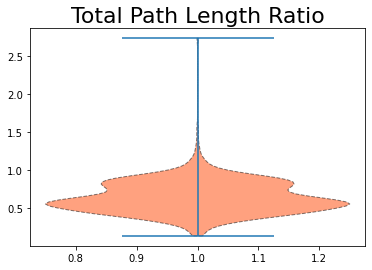

In [248]:
length_data = df_gs1891_plot['swc1891_42k_length']/df_gs1891_plot['swc1891_gs_length']
fig = plt.violinplot(length_data)
for pc in fig["bodies"]:
    print(pc)
    pc.set_facecolor("orangered")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)
    pc.set_linestyle("--")
#plt.scatter(np.random.normal(1, 0.08, len(v)), v, s=3, color='orangered')
plt.title('Total Path Length Ratio',fontsize=22)
plt.savefig('./path_dist_ratio_hist.png')

In [266]:
from neuron_dist import calc_score      
def clac_score(df,para=20.0):
    ESA_gs = []
    ESA_reon = []
    ESA = []
    DSA_gs = []
    DSA_recon = []
    DSA = []
    PDS_gs = []
    PDS_recon = []
    PDS = []
    iswc = 0
    t0 = time.time()
    for i,gs in df.iterrows():
        mannual = gs['swc1891_gsfile']
        recons = gs['swc1891_42kfile']
        dist = calc_score(mannual,recons,para)
        ESA_gs.append(dist['ESA'][0])
        ESA_reon.append(dist['ESA'][1])
        ESA.append(dist['ESA'][2])
        DSA_gs.append(dist['DSA'][0])
        DSA_recon.append(dist['DSA'][1])
        DSA.append(dist['DSA'][2])
        PDS_gs.append(dist['PDS'][0])
        PDS_recon.append(dist['PDS'][1])
        PDS.append(dist['PDS'][2])      
        iswc += 1
        if iswc % 3 ==  0:
            print(f'--> {iswc} in {time.time() - t0:.2f} s')   
    return ESA_gs,ESA_reon,ESA,DSA_gs,DSA_recon,DSA,PDS_gs,PDS_recon,PDS

ESA_gs,ESA_reon,ESA,DSA_gs,DSA_recon,DSA,PDS_gs,PDS_recon,PDS = clac_score(df_gs1891_plot)  
for item in f'ESA_gs,ESA_reon,ESA,DSA_gs,DSA_recon,DSA,PDS_gs,PDS_recon,PDS'.split(','):
    df_gs1891_plot[item] = eval(item)
df_gs1891_plot.to_csv('./manal1891_42krecon1330_14896plot858.csv')
df_gs1891_plot

--> 3 in 45.63 s
--> 6 in 78.23 s
--> 9 in 110.94 s
--> 12 in 134.86 s
--> 15 in 163.53 s
--> 18 in 213.60 s
--> 21 in 247.67 s
--> 24 in 290.39 s
--> 27 in 332.58 s
--> 30 in 397.81 s
--> 33 in 433.59 s
--> 36 in 479.42 s
--> 39 in 514.11 s
--> 42 in 547.27 s
--> 45 in 587.72 s
--> 48 in 628.47 s
--> 51 in 652.27 s
--> 54 in 732.76 s
--> 57 in 784.96 s
--> 60 in 842.85 s
--> 63 in 897.02 s
--> 66 in 917.67 s
--> 69 in 952.57 s
--> 72 in 991.99 s
--> 75 in 1020.39 s
--> 78 in 1065.84 s
--> 81 in 1115.73 s
--> 84 in 1147.14 s
--> 87 in 1198.06 s
--> 90 in 1230.84 s
--> 93 in 1255.00 s
--> 96 in 1276.88 s
--> 99 in 1298.34 s
--> 102 in 1324.94 s
--> 105 in 1366.01 s
--> 108 in 1411.66 s
--> 111 in 1472.64 s
--> 114 in 1555.42 s
--> 117 in 1657.42 s
--> 120 in 1718.45 s
--> 123 in 1784.14 s
--> 126 in 1820.13 s
--> 129 in 1867.52 s
--> 132 in 1967.14 s
--> 135 in 2030.16 s
--> 138 in 2094.59 s
--> 141 in 2242.84 s
--> 144 in 2373.75 s
--> 147 in 2483.58 s
--> 150 in 2519.46 s
--> 153 in 2

,brainid,raw_somaxyz,swc42k_raw_somaxyz,swc42k_raw_somaxyz_dist,swc1891_swcfile,swc1891_raw_somaxyz,swc1891_raw_somaxyz_dist,raw_somaregion,regi_somaxyz,swc42k_regi_somaxyz,...,swc1891_gs_length,ESA_gs,ESA_reon,ESA,DSA_gs,DSA_recon,DSA,PDS_gs,PDS_recon,PDS
5502,15257,"[13261.242, 25519.086, 2289.98]","[13261.24, 25519.0, 2289.98]",0.086023,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[13263.808 25518.4 2294.128],4.925531,NaN,"[134.171, 163.263, 126.921]","[133.948, 163.407, 126.948]",...,26228.485554,37.606482,2.400081,20.003282,72.377428,36.641558,54.509493,0.492577,0.003002,0.247789
5869,15257,"[16399.938, 21559.73, 4018.632]","[16399.94, 21559.8, 4018.64]",0.070484,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[16402.305 21557.695 4020.896],3.856113,NaN,"[219.038, 67.394, 195.256]","[218.852, 67.539, 195.316]",...,12323.464129,26.541232,4.768690,15.654961,80.896680,82.178698,81.537689,0.293013,0.031036,0.162025
6901,17109,"[6760.03, 6208.625, 4161.819]","[6760.02, 6208.62, 4161.82]",0.011225,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[6758.784 6199.168 4163.6 ],9.703573,NaN,"[241.42899999999997, 124.773, 85.207]","[241.207, 124.714, 85.073]",...,18822.354384,47.023337,3.096365,25.059851,96.031875,43.329302,69.680589,0.475496,0.024820,0.250158
6904,17109,"[6624.767, 5736.219, 4766.702]","[6624.76, 5736.22, 4766.7]",0.007348,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[6621.312 5731.904 4770.304],6.597776,NaN,"[272.094, 119.564, 78.668]","[271.882, 119.508, 78.554]",...,12467.555259,29.628237,9.058378,19.343307,75.834448,42.811511,59.322980,0.353288,0.130556,0.241922
6928,17109,"[9502.57, 8169.406, 2696.72]","[9502.58, 8169.4, 2696.72]",0.011662,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[9504.256 8167.808 2700.528],4.460613,NaN,"[166.198, 186.175, 105.797]","[166.074, 186.137, 105.677]",...,11305.384749,10.946687,11.177776,11.062232,46.212098,57.093147,51.652622,0.190502,0.163560,0.177031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227543,236174,"[15151.86, 26699.66, 3781.118]","[15151.86, 26699.6, 3781.12]",0.060033,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15156.288 26697.92 3782.4 ],4.927302,NaN,"[205.257, 190.729, 368.943]","[205.086, 190.686, 368.895]",...,11558.432650,8.211238,45.354565,26.782901,38.416368,100.584691,69.500529,0.138039,0.427085,0.282562
227547,236174,"[15241.354, 29743.209, 5953.089]","[15241.36, 29743.2, 5953.08]",0.014071,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15239.488 29744.32 5956.128],3.735211,NaN,"[294.57, 174.11, 408.336]","[294.411, 174.067, 408.277]",...,17014.728414,37.579423,1.538163,19.558793,82.190643,29.682733,55.936688,0.438127,0.004617,0.221372
227551,236174,"[15535.112, 29852.23, 6835.208]","[15535.12, 29852.2, 6835.2]",0.032062,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[15535.296 29853.568 6837.008],2.250356,NaN,"[331.182, 171.451, 408.439]","[331.002, 171.431, 408.366]",...,15775.403758,41.239980,11.874828,26.557404,97.612208,99.060829,98.336518,0.401100,0.094259,0.247680
227558,236174,"[16213.69, 10304.088, 4113.665]","[16213.7, 10304.08, 4113.66]",0.013748,/PBshare/SEU-ALLEN/Projects/fullNeurons/V2023_...,[16212.288 10306.304 4116.688],4.001848,NaN,"[211.749, 238.106, 122.699]","[211.546, 238.059, 122.597]",...,13854.289422,17.983519,2.071595,10.027557,52.962766,21.237362,37.100064,0.286858,0.000613,0.143736


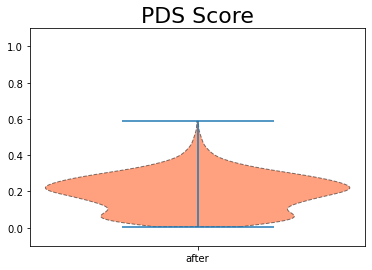

In [272]:
data_pds = df_gs1891_plot['PDS']
fig = plt.violinplot(data_pds)
for pc in fig["bodies"]:
    print(pc)
    pc.set_facecolor("orangered")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)
    pc.set_linestyle("--")
# for i, v in enumerate(data_pds.values()):
#     plt.scatter(np.random.normal(i + 1, 0.08, len(v)), v, s=3, color='orangered')
plt.xticks([1], ['after'])
plt.ylim([-0.1, 1.1])
plt.title('PDS Score',fontsize=22)
plt.savefig('pds_diff.png')

In [273]:
__FEAT_NAMES__ = [
    'Nodes', 'SomaSurface', 'Stems', 'Bifurcations',
    'Branches', 'Tips', 'OverallWidth', 'OverallHeight', 'OverallDepth',
    'AverageDiameter', 'Length', 'Surface', 'Volume',
    'MaxEuclideanDistance', 'MaxPathDistance', 'MaxBranchOrder',
    'AverageContraction', 'AverageFragmentation',
    'AverageParent-daughterRatio', 'AverageBifurcationAngleLocal',
    'AverageBifurcationAngleRemote', 'HausdorffDimension']

def calc_global_features(swc_file, vaa3d='/home/lyf/Softwares/installation/Vaa3D/v3d_external/bin/vaa3d'):
    cmd_str = f'xvfb-run -a -s "-screen 0 640x480x16" {vaa3d} -x global_neuron_feature -f compute_feature -i {swc_file}'
    p = subprocess.check_output(cmd_str, shell=True)
    output = p.decode().splitlines()[32:-2]
    info_dict = {}
    for s in output:
        it1, it2 = s.split(':')
        it1 = it1.strip()
        it2 = it2.strip()
        info_dict[it1] = float(it2)

    # extract the target result
    #print(info_dict)
    features = []
    features.append(int(info_dict['N_node']))
    features.append(info_dict['Soma_surface'])
    features.append(int(info_dict['N_stem']))
    features.append(int(info_dict['Number of Bifurcatons']))
    features.append(int(info_dict['Number of Branches']))
    features.append(int(info_dict['Number of Tips']))
    features.append(info_dict['Overall Width'])
    features.append(info_dict['Overall Height'])
    features.append(info_dict['Overall Depth'])
    features.append(info_dict['Average Diameter'])
    features.append(info_dict['Total Length'])
    features.append(info_dict['Total Surface'])
    features.append(info_dict['Total Volume'])
    features.append(info_dict['Max Euclidean Distance'])
    features.append(info_dict['Max Path Distance'])
    features.append(info_dict['Max Branch Order'])
    features.append(info_dict['Average Contraction'])
    features.append(info_dict['Average Fragmentation'])
    features.append(info_dict['Average Parent-daughter Ratio'])
    features.append(info_dict['Average Bifurcation Angle Local'])
    features.append(info_dict['Average Bifurcation Angle Remote'])
    features.append(info_dict['Hausdorff Dimension'])

    return features

def calc_global_features_all(df, outfile,):
    features_all = []
    iswc = 0
    t0 = time.time()
    for i,gs in df.iterrows():
        region = gs['regi_somaregion_check']
        mannual = gs['swc1891_gsfile']
        recons = gs['swc1891_42kfile']              
        features2 = calc_global_features(mannual)
        features_all.append([mannual, 'manual', region, *features2])
        features1 = calc_global_features(recons)
        features_all.append([mannual, 'recons', region, *features1])
        
        iswc += 1
        if iswc % 5 ==  0:
            print(f'--> {2*iswc} in {time.time() - t0:.2f} s')
    df = pd.DataFrame(features_all, columns=['file', 'compare', 'region', *__FEAT_NAMES__])
    df.to_csv(outfile, float_format='%g', index=False)
    return df

outfile = './lm_gs_adapt.csv'
df_gs1891_plot_features = calc_global_features_all(df_gs1891_plot,outfile)
df_gs1891_plot_features

,file,compare,region,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,OverallWidth,...,Volume,MaxEuclideanDistance,MaxPathDistance,MaxBranchOrder,AverageContraction,AverageFragmentation,AverageParent-daughterRatio,AverageBifurcationAngleLocal,AverageBifurcationAngleRemote,HausdorffDimension
0,./adapt_box/15257/210254_2309_x13266_y25533.swc,manual,AId5,11966,12.566371,9,84,175,92,832.745,...,82399.2,677.970,1277.020,17.0,0.900227,67.37140,1.000000,78.9620,73.9720,1.17570
1,./adapt_box/15257/210254_2309_x13266_y25533.swc,recons,AId5,609,1017.876020,2,34,72,39,832.980,...,68184.0,628.932,1185.450,11.0,0.944713,7.44444,0.859061,57.5650,62.8764,1.21223
2,./adapt_box/15257/210254_4021_x16401_y21556.swc,manual,MOs6a,5650,12.566371,6,40,84,45,821.361,...,38715.3,681.800,956.576,17.0,0.922334,66.25000,1.000000,75.5728,82.5879,1.09483
3,./adapt_box/15257/210254_4021_x16401_y21556.swc,recons,MOs6a,404,452.389342,5,26,56,31,829.999,...,43449.5,693.573,769.503,14.0,0.941106,6.19643,0.882738,60.0468,68.4402,1.16421
4,./adapt_box/17109/17109_4101_x6753_y6197.swc,manual,SSp-n6a,8044,12.566371,5,72,147,76,679.632,...,59132.2,686.005,1325.500,9.0,0.942363,53.71430,1.000000,77.5211,69.2543,1.07315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,./adapt_box/236174/236174_6855_x15550_y29832.swc,recons,ECT5,551,1809.557368,7,35,75,41,1022.000,...,85009.4,613.329,1187.950,6.0,0.933976,6.33333,0.885000,54.4855,58.1359,1.25570
1712,./adapt_box/236174/236174_4129_x16214_y10304.swc,manual,FS,5867,12.566371,9,55,117,63,780.863,...,43524.5,493.739,1202.950,10.0,0.947383,49.13680,1.000000,72.0551,64.1096,1.15500
1713,./adapt_box/236174/236174_4129_x16214_y10304.swc,recons,FS,431,1017.876020,5,32,67,36,781.999,...,47118.0,480.436,489.565,8.0,0.966317,5.41791,0.824106,51.3288,47.7880,1.33391
1714,./adapt_box/236174/236174_3829_x16301_y26647.swc,manual,AIp6a,4948,12.566371,7,60,125,66,568.763,...,34740.4,596.451,1073.500,7.0,0.931954,38.57600,1.000000,80.0937,74.8536,1.17711


In [297]:
__FEAT_NAMES__

['Nodes',
 'SomaSurface',
 'Stems',
 'Bifurcations',
 'Branches',
 'Tips',
 'OverallWidth',
 'OverallHeight',
 'OverallDepth',
 'AverageDiameter',
 'Length',
 'Surface',
 'Volume',
 'MaxEuclideanDistance',
 'MaxPathDistance',
 'MaxBranchOrder',
 'AverageContraction',
 'AverageFragmentation',
 'AverageParent-daughterRatio',
 'AverageBifurcationAngleLocal',
 'AverageBifurcationAngleRemote',
 'HausdorffDimension']

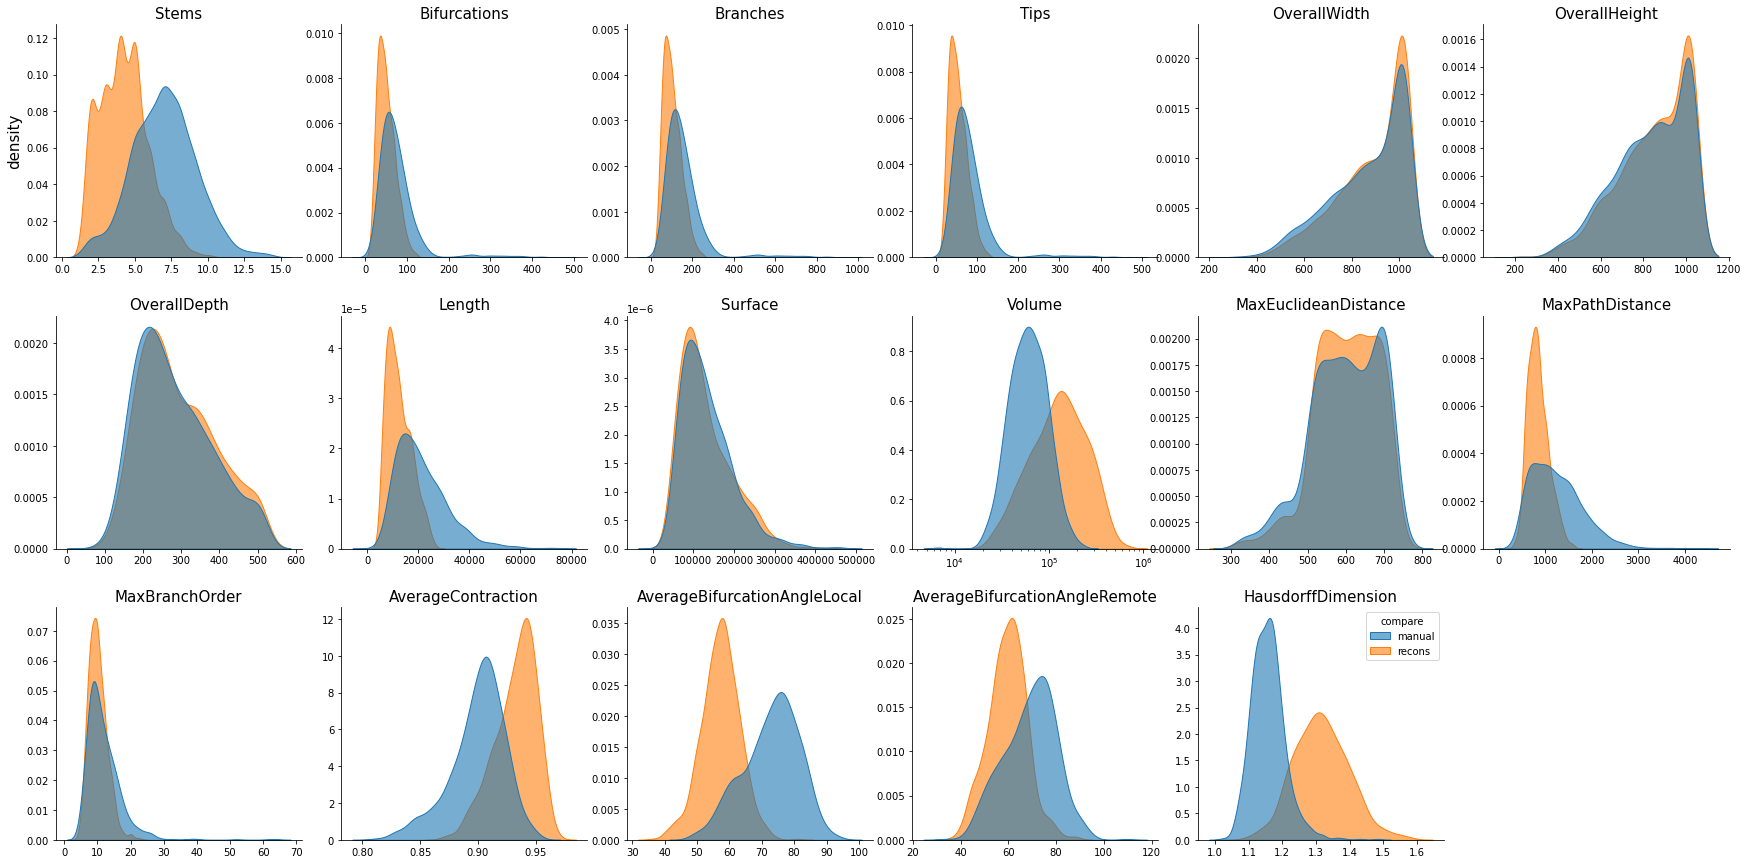

In [321]:
h = 3
w = 6
font = 15
fig = plt.figure(figsize=(w*5,h*5))
index = list(range(2,9))+list(range(10,17))+list(range(19,22))
for i,f in enumerate(index):
    feature = __FEAT_NAMES__[f]
    log = False
    if f in [0,12,17]:log=True
    
    axes = fig.add_subplot(h,w,i+1)
    sns.kdeplot(data=df_gs1891_plot_features, x=feature, hue="compare", 
                log_scale=log,
                #alpha = 0.1, bins = b,
                bw_adjust=1.0, fill=True, alpha=0.6)
    #sns.histplot(tab_plot, x='sum', hue="source", kde=True, legend=None, ax=axes[i,j])#alpha = 0.1, bins = b,
    axes.set_title(feature,fontsize=font)
    #axes.text(0,2,feature,va='top',ha='center',fontsize=font)
    axes.set_xlabel('')
    axes.set_ylabel('density',fontsize=font)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)    
#     if feature=='Branch_Order': axes[i,j].set_ylim([0,100])
#     if not feature=='Bif_ampl_local': 
#         axes[i,j].get_legend().remove()

    if i:
        axes.set_xlabel('')
        axes.set_ylabel('') 
    if f != 21:
        axes.get_legend().remove()
                
plt.subplots_adjust(wspace=0.16,hspace=0.25)
plt.savefig('./comparison.png')
plt.show()



# history

In [ ]:
raw_sec_soma_name_list = glob.glob("1741/sorted_recon/*/*.swc")
for s,raw_sec_soma_name in enumerate(raw_sec_soma_name_list):
    sx,sy,sz = [int(c) for c in os.path.basename(raw_sec_soma_name).replace('.swc','').split('_')]#512 512 256
    mx,my,mz = [c*2 for c in [sx,sy,sz]]
    raw_max_soma_name = os.path.dirname(raw_sec_soma_name).replace('sorted_recon','max_1024') + f'/{mx}_{my}_{mz}.swc'

    tree = parse_swc(raw_sec_soma_name)
    new_tree = []
    for leaf in tree:
        i,t,x,y,z,r,p = leaf
        x = 2*(x + sx - 256)
        y = 2*(y + sy - 256)
        z = 2*(z + sz - 128)
        new_tree.append((i,t,x,y,z,r,p))
    
    if not os.path.exists(os.path.dirname(raw_max_soma_name)): os.makedirs(os.path.dirname(raw_max_soma_name))
    write_swc(new_tree,raw_max_soma_name)
    
    print(s,raw_sec_soma_name,'\n',raw_max_soma_name,'\n')
    

In [ ]:
sx,sy,sz

In [ ]:
raw_sec_soma_name.replace('sorted_recon','max_1024').replace(str(sx),str(mx)).replace(str(sy),str(my)).replace('1845','3690')

In [ ]:
df = pd.read_csv('1741/ana_neurons_soma_regions-jsd1101.csv',)
r,c = np.unique(df['region'],return_counts=True)

In [ ]:
len(r)

In [ ]:
gs_dir = Path('gs_refined_512')
swc_dir = Path('../stage5_consensus/out')
data_length = {}
for s in swc_dir.rglob("*.swc"):
    gs_tree = gs_dir / s.relative_to(swc_dir)
    if not gs_tree.exists():
        continue
    tree2 = swc_handler.parse_swc(gs_tree)
    tree1 = swc_handler.parse_swc(s)
    morph1 = Morphology(tree1)
    morph2 = Morphology(tree2)
    a = morph1.calc_total_length()
    b = morph2.calc_total_length()
    data_length[s] = a / b
v = data_length.values()
fig = plt.violinplot(v)
for pc in fig["bodies"]:
    print(pc)
    pc.set_facecolor("orangered")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)
    pc.set_linestyle("--")

#plt.scatter(np.random.normal(1, 0.08, len(v)), v, s=3, color='orangered')
plt.title('Total Path Length Ratio',fontsize=22)
plt.savefig('path_dist_ratio_hist.png')

In [ ]:
tab_diff = pd.read_csv('peng_metrics_diff.csv')
data_pds = tab_diff[['pds8_after']].to_dict(orient='series')
fig = plt.violinplot(data_pds.values(), )
for pc in fig["bodies"]:
    print(pc)
    pc.set_facecolor("orangered")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)
    pc.set_linestyle("--")
# for i, v in enumerate(data_pds.values()):
#     plt.scatter(np.random.normal(i + 1, 0.08, len(v)), v, s=3, color='orangered')
plt.xticks([1], ['after'])
plt.ylim([-0.1, 1.1])
plt.title('PDS Score',fontsize=22)
plt.savefig('pds_diff.png')

In [ ]:
tab_gs = pd.read_csv('Lm_gs.txt', sep='\t', names=['path','metric', 'sum', 'compartments', 'compartments(discarded)', 'min','avg', 'max', 'sd'], usecols=[0, 1, 2, 5, 6, 7, 8], index_col=0)
tab_recon = pd.read_csv('Lm_recon.txt', sep='\t', names=['path', 'metric', 'sum', 'compartments', 'compartments(discarded)', 'min','avg', 'max', 'sd'], usecols=[0, 1, 2, 5, 6, 7, 8], index_col=0)
tab_gs['metric'] = tab_gs['metric'].str.replace(' Lim', '')
tab_recon['metric'] = tab_recon['metric'].str.replace(' ', '')
tab_gs['source'] = [i[0] for i in tab_gs.index.str.split('_')]
tab_recon['source'] = [i[0] for i in tab_recon.index.str.split('_')]
tab_gs['neuron'] = [i[-2] + '/' + i[-1] for i in tab_gs.index.str.split('/')]
tab_recon['neuron'] = [i[-2] + '/' + i[-1] for i in tab_recon.index.str.split('/')]
tab_total = pd.concat([tab_gs,tab_recon], axis=0)

total = tab_total.pivot_table(values=['sum','min','avg','max','sd'], columns=['metric'], index=['source','neuron'], )#aggfunc=lambda x: x.index)
total

In [ ]:
feature = np.unique(tab_total["metric"].values)
num = len(feature)
fig, axes = plt.subplots(8, 8,figsize=(30, 30)) #Prepare plot areas
i = 0
row = 0
col = 0
for c in range(num):
    tab_plot = tab_total[tab_total['metric']==feature[c]]
    try:
        sns.histplot(tab_plot, x='sum', hue="source", kde=True, ax=axes[int(i/8),i%8])#alpha = 0.1, bins = b,
        axes[int(i/8),i%8].set_xlabel('value')
        if feature[c]=='Branch_Order': axes[int(i/8),i%8].set_ylim([0,100])
        if feature[c]=='EucDistance': axes[int(i/8),i%8].set_ylim([0,200])
        if feature[c]=='PathDistance': axes[int(i/8),i%8].set_ylim([0,100])
        axes[int(i/8),i%8].set_title(feature[c]+' sum',fontsize=16)
        if not feature[c]=='Bif_ampl_local': 
            axes[int(i/8),i%8].get_legend().remove()
        i += 1
    except:
        print(f'{feature[c]} sum plot error')
    try:
        sns.histplot(tab_plot, x='avg', hue="source", kde=True, legend=None, ax=axes[int(i/8),i%8])#alpha = 0.1, bins = b,
        axes[int(i/8),i%8].set_xlabel('value')
        if feature[c]=='Length': axes[int(i/8),i%8].set_ylim([0,200])
        if feature[c]=='N_stems': axes[int(i/8),i%8].set_ylim([0,500])
        if feature[c]=='Parent_Daughter_Ratio': axes[int(i/8),i%8].set_ylim([0,150])
        if feature[c]=='Volume': axes[int(i/8),i%8].set_ylim([0,200])
        axes[int(i/8),i%8].set_title(feature[c]+' avg',fontsize=16)
        i += 1
    except:
        print(f'{feature[c]} avg plot error')
    try:
        sns.histplot(tab_plot, x='max', hue="source", kde=True, legend=None, ax=axes[int(i/8),i%8])#alpha = 0.1, bins = b,
        axes[int(i/8),i%8].set_xlabel('value')
        if feature[c]=='Contraction': axes[int(i/8),i%8].set_ylim([0,50])
        if feature[c]=='Length': axes[int(i/8),i%8].set_ylim([0,200])
        if feature[c]=='N_stems': axes[int(i/8),i%8].set_ylim([0,20])
        if feature[c]=='Parent_Daughter_Ratio': axes[int(i/8),i%8].set_ylim([0,150])
        if feature[c]=='Volume': axes[int(i/8),i%8].set_ylim([0,200])
        axes[int(i/8),i%8].set_title(feature[c]+' max',fontsize=16)    
        i += 1
    except:
        print(f'{feature[c]} max plot error')
    try:
        sns.histplot(tab_plot, x='min', hue="source", kde=True, legend=None, ax=axes[int(i/8),i%8])#alpha = 0.1, bins = b,
        axes[int(i/8),i%8].set_xlabel('value')
        if feature[c]=='EucDistance': axes[int(i/8),i%8].set_ylim([0,200])
        if feature[c]=='Length': axes[int(i/8),i%8].set_ylim([0,250])
        if feature[c]=='N_stems': axes[int(i/8),i%8].set_ylim([0,20])
        if feature[c]=='PathDistance': axes[int(i/8),i%8].set_ylim([0,100])
        if feature[c]=='Volume': axes[int(i/8),i%8].set_ylim([0,200])
        axes[int(i/8),i%8].set_title(feature[c]+' min',fontsize=16)
        i += 1
    except:
        print(f'{feature[c]} min plot error')
    try:
        sns.histplot(tab_plot, x='sd', hue="source", kde=True, legend=None, ax=axes[int(i/8),i%8])#alpha = 0.1, bins = b,
        axes[int(i/8),i%8].set_xlabel('value')
        if feature[c]=='Parent_Daughter_Ratio': axes[int(i/8),i%8].set_ylim([0,500])
        if feature[c]=='Volume': axes[int(i/8),i%8].set_ylim([0,200])
        axes[int(i/8),i%8].set_title(feature[c]+' sd',fontsize=16)
        i += 1
    except:
        print(f'{feature[c]} std plot error')
for c in range(i,64):
    axes[int(c/8),c%8].set_xticks([])
    axes[int(c/8),c%8].spines['top'].set_visible(False)
    axes[int(c/8),c%8].spines['bottom'].set_visible(False)
    axes[int(c/8),c%8].spines['left'].set_visible(False)
    axes[int(c/8),c%8].spines['right'].set_visible(False)
    axes[int(c/8),c%8].set_yticks([])
plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.savefig('total.png')
plt.show()


In [ ]:
fig, axes = plt.subplots(5,5,figsize=(20, 20))
f = 20

tab_plot = tab_total.query('metric=="Bif_ampl_local"')
#sns.histplot(tab_plot, x='avg', hue="source", kde=True, ax=axes[0,3])#alpha = 0.1, bins = b,
sns.kdeplot(data=tab_plot, x='avg', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[0,3])#alpha = 0.1, bins = b,
axes[0,3].set_title("Bif_ampl_local avg",fontsize=f)

tab_plot = tab_total.query('metric=="Bif_ampl_local"')
sns.kdeplot(data=tab_plot, x='sd', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[0,4])
axes[0,4].set_title("Bif_ampl_local std",fontsize=f)

tab_plot = tab_total.query('metric=="Bif_ampl_remote"')
sns.kdeplot(data=tab_plot, x='avg', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[1,0])
axes[1,0].set_title("Bif_ampl_remote avg",fontsize=f)

tab_plot = tab_total.query('metric=="Bif_ampl_remote"')
sns.kdeplot(data=tab_plot, x='sd', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[1,1])
axes[1,1].set_title("Bif_ampl_remote std",fontsize=f)

tab_plot = tab_total.query('metric=="Branch_Order"')
sns.kdeplot(data=tab_plot, x='avg', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[1,2])
axes[1,2].set_title("Branch_Order avg",fontsize=f)

tab_plot = tab_total.query('metric=="Branch_Order"')
sns.kdeplot(data=tab_plot, x='max', hue="source", bw_adjust=1, fill=True, alpha=0.5, ax=axes[1,3])
axes[1,3].set_title("Branch_Order max",fontsize=f)

tab_plot = tab_total.query('metric=="Branch_Order"')
sns.kdeplot(data=tab_plot, x='sd', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[1,4])
axes[1,4].set_title("Branch_Order std",fontsize=f)

tab_plot = tab_total.query('metric=="N_branch"')
sns.kdeplot(data=tab_plot, x='sum', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[2,0])
axes[2,0].set_title("N_branch sum",fontsize=f)

tab_plot = tab_total.query('metric=="N_stems"')
sns.kdeplot(data=tab_plot, x='sum', hue="source", bw_adjust=1, fill=True, alpha=0.5, ax=axes[2,1])
axes[2,1].set_title("N_stems",fontsize=f)

tab_plot = tab_total.query('metric=="N_tips"')
sns.kdeplot(data=tab_plot, x='sum', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[2,2])
axes[2,2].set_title("N_tips",fontsize=f)

tab_plot = tab_total.query('metric=="Contraction"')
sns.kdeplot(data=tab_plot, x='avg', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[2,3])
axes[2,3].set_title("Contraction avg",fontsize=f)

tab_plot = tab_total.query('metric=="Contraction"')
sns.kdeplot(data=tab_plot, x='sd', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[2,4])
axes[2,4].set_title("Contraction std",fontsize=f)

# tab_plot = tab_total.query('metric=="Depth"')
# sns.kdeplot(data=tab_plot, x='max', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[3,0])
# axes[3,0].set_title("Depth",fontsize=f)

tab_plot = tab_total.query('metric=="Parent_Daughter_Ratio"')#calculating problem
sns.kdeplot(data=tab_plot, x='sum', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[3,0])
axes[3,0].set_title("Parent_Daughter_Ratio sum",fontsize=f)

tab_plot = tab_total.query('metric=="Height"')
sns.kdeplot(data=tab_plot, x='max', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[3,1])
axes[3,1].set_title("Height",fontsize=f)

tab_plot = tab_total.query('metric=="Length"')
sns.kdeplot(data=tab_plot, x='sum', hue="source", bw_adjust=.5, log_scale=True, fill=True, alpha=0.5, ax=axes[3,2])
axes[3,2].set_title("Length",fontsize=f)

tab_plot = tab_total.query('metric=="Length"')
sns.kdeplot(data=tab_plot, x='sd', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[3,3])
axes[3,3].set_title("Length std",fontsize=f)

# tab_plot = tab_total.query('metric=="Width"')
# sns.kdeplot(data=tab_plot, x='max', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[3,4])
# axes[3,4].set_title("Width",fontsize=f)

tab_plot = tab_total.query('metric=="Volume"')
sns.kdeplot(data=tab_plot, x='sum', hue="source", bw_adjust=.5, log_scale=True, fill=True, alpha=0.5, ax=axes[3,4])
axes[3,4].set_title("Volume",fontsize=f)

tab_plot = tab_total.query('metric=="PathDistance"')
sns.kdeplot(data=tab_plot, x='avg', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[4,0])
axes[4,0].set_title("PathDistance",fontsize=f)

tab_plot = tab_total.query('metric=="PathDistance"')
sns.kdeplot(data=tab_plot, x='sd', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[4,1])
axes[4,1].set_title("PathDistance std",fontsize=f)

tab_plot = tab_total.query('metric=="EucDistance"')
sns.kdeplot(data=tab_plot, x='max', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[4,2])
axes[4,2].set_title("EucDistance max",fontsize=f)

tab_plot = tab_total.query('metric=="EucDistance"')
sns.kdeplot(data=tab_plot, x='avg', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[4,3])
axes[4,3].set_title("EucDistance avg",fontsize=f)

tab_plot = tab_total.query('metric=="EucDistance"')
sns.kdeplot(data=tab_plot, x='sd', hue="source", bw_adjust=.5, fill=True, alpha=0.5, ax=axes[4,4])
axes[4,4].set_title("EucDistance std",fontsize=f)

for i in range(25):
    r,c = [int(i/5),i%5]
    try:
        axes[r,c].get_legend().remove()
        axes[r,c].set_xlabel("value",fontsize=17)
        axes[r,c].set_ylabel("density",fontsize=17)
    except:
        axes[r,c].set_xticks([])
        axes[r,c].spines['top'].set_visible(False)
        axes[r,c].spines['bottom'].set_visible(False)
        axes[r,c].spines['left'].set_visible(False)
        axes[r,c].spines['right'].set_visible(False)
        axes[r,c].set_yticks([])       
plt.subplots_adjust(wspace=0.35,hspace=0.6)
plt.savefig('comparison.png')
plt.show()

In [ ]:
region_ref = pd.read_csv('200k_region_20220929.csv',names=['path_max','region'],header=0,index_col=0)
source_dict = {}
with open('test.txt','r') as f: 
    for line in f.readlines():
        if line[0]=='#': continue
        #print(line)
        line = line.strip()
        k,v = line.split('=')
        v = v.replace('-','').replace('1','').replace('3','')
        dict_str = f"source_dict['{k}']={v}"
        #print(dict_str)
        exec(dict_str)
        
def find_key(ref_dict,find_value):
    if find_value in ref_dict.keys(): return find_value
    for k,v in ref_dict.items():
        if find_value in v: return k
    return 'unknown'

import re
unknown_path = []
unknown_region = []
known_region = []
for i,lm_file in enumerate(glob.glob('../../230k_lj/Lm_recon_*.txt')):
    #print(lm_file)
    if i: tab_old = tab_lm_tmp
    tab_lm_tmp = pd.read_csv(lm_file, sep='\t', names=['path', 'metric', 'sum', 'compartments', 'compartments(discarded)', 'min','avg', 'max', 'sd'], usecols=[0, 1, 6, 8], index_col=0)
    tab_lm_tmp['metric'] = tab_lm_tmp['metric'].str.replace(' Lim', '').replace(' ', '')
    tab_lm_tmp['neuron'] = [i[-2] + '/' + i[-1] for i in tab_lm_tmp.index.str.split('/')]
    
    region = []
    source = []
    for ii in tab_lm_tmp.index:
        path_xyz = [round(float(xyz)*2) for xyz in ii.split('.v3dpbd.swc')[0].split('_')[-5::2]]
        path_brain = ii.split('/')[2]
        path_max = '200k_'+path_brain+'_'+str(path_xyz[0])+'_'+str(path_xyz[1])+'_'+str(path_xyz[2])
        try:
            r = region_ref.loc[path_max,'region'].replace('-','')
            r = re.split(r'[0123456789]',r)[0]
            region.append(r)
            s = find_key(source_dict,r)
            if s=='unknown': unknown_region.append(r)
            else: known_region.append(r)
            source.append(s)
        except:
            unknown_path.append(path_max)
            region.append('unknown')
            source.append('unknown')
    tab_lm_tmp['region'] = region
    tab_lm_tmp['source'] = source
    
    if i: tab_lm = pd.concat([tab_lm_tmp,tab_lm], axis=0)
    else: tab_lm = tab_lm_tmp
tab_lm

In [ ]:
unknown_path = np.unique(np.array(unknown_path))
print(len(unknown_path))
unknown_region = np.unique(np.array(unknown_region))
print(unknown_region)
known_region = np.unique(np.array(known_region))
print(known_region)
tab_lm = tab_lm[np.array(tab_lm['source'])!='unknown']
tab_lm

In [ ]:
tab_sort = tab_lm.pivot_table(values=['avg','sd'], columns=['metric'], index=['source','region','neuron'], )
lm_data = ( tab_sort.values-tab_sort.values.mean(axis=0) )/( tab_sort.values.std(axis=0) )
print(lm_data.min(axis=0),lm_data.max(axis=0))
del_index = [8,9,10,19,21,23,24,25,29]
lm_data = np.delete(lm_data, del_index, axis = 1)
col = [ii[0]+'_'+ii[1] for i,ii in enumerate(tab_sort.columns)]
col = [ii for i,ii in enumerate(col) if i not in del_index]
lm_source = [i[0] for i in tab_sort.index]
lm_region = [i[1] for i in tab_sort.index]
lm_neuron = [i[2] for i in tab_sort.index]
lm_sort = pd.DataFrame(lm_data,columns=col,index=lm_neuron)
lm_sort['region']=lm_region
lm_sort['source']=lm_source
lm_sort

In [ ]:
lm_df = pd.pivot_table(lm_sort,index=['source','region'])
# lm_df = lm_df[np.array([i[0] for i in lm_df.index])!='CTX']
lm_df = lm_df[np.array([i[0] for i in lm_df.index])!='TH']
# lm_df = lm_df[np.array([i[0] for i in lm_df.index])!='CB']
lm_df = lm_df[np.array([i[0] for i in lm_df.index])!='CNU']
# lm_df = lm_df[np.array([i[0] for i in lm_df.index])!='HB']
lm_df = lm_df[np.array([i[0] for i in lm_df.index])!='HY']
lm_df = lm_df[np.array([i[0] for i in lm_df.index])!='MB']
lm_df

In [ ]:
region_color = []
for i in lm_df.index:
    r = i[0]
    if r=='CTX': region_color.append('black')
    if r=='TH': region_color.append('green')
    if r=='HB': region_color.append('yellow')
    if r=='CNU': region_color.append('red')
    if r=='MB': region_color.append('orange')
    if r=='CB': region_color.append('blue')
    if r=='HY': region_color.append('cyan')
    if r=='unknown': region_color.append('white')
region_color=np.array(region_color)
lm_plot = pd.DataFrame(lm_df.values,index=[i[1] for i in lm_df.index],columns=col)

new_blues=sns.color_palette("Blues", 1000)
new_oranges=sns.color_palette("Oranges", 1000)
new_oranges.reverse()
new = new_oranges+new_blues

sns.clustermap(lm_plot,cmap='bwr',cbar_pos=(0.1,0.05,0.02,0.15),#bwr#coolwarm#Spectral#RdBu
                 row_colors=region_color,figsize=(12,13),)
#                col_colors='metric
#                dendrogram_ratio=(.1,.2))
plt.savefig('cluster.png')